# Imports

In [1]:
# %matplotlib notebook
%pip install numpy seaborn matplotlib pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.manifold import TSNE

from sklearn.neighbors import LocalOutlierFactor as LOF
from sklearn.ensemble import IsolationForest as IF
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, silhouette_score

from sklearn.cluster import KMeans, AgglomerativeClustering, HDBSCAN
from sklearn.mixture import GaussianMixture


https://www.kaggle.com/datasets/ghoshsaibal/creditcard

# Analiza

## Ucitavanje podataka

In [3]:
def csv_to_pd(path):
    return pd.read_csv(path)

def pandas_uniques(df, col_name):
    counts = df[col_name].value_counts()
    unique = df[col_name].unique()
    return unique,counts

def print_uniques(df, cols, count_per_categ=False):
    for c in cols:
        print()
        print(c)
        print("-----------------")
        u, b = pandas_uniques(df,c)
        print("\tVrednosti: ",u)
        print("\tBroj jedinstvenih: ",len(u))
    
        if not count_per_categ: continue
        print("\tJedinstvenih:")
        for i in range(len(b)):
            print("\t",b.iloc[i])
applications = csv_to_pd("./data/application_record.csv")
credits = csv_to_pd("./data/credit_record.csv")

In [4]:
applications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [5]:
cols = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',\
        'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
print_uniques(applications,cols)


CODE_GENDER
-----------------
	Vrednosti:  ['M' 'F']
	Broj jedinstvenih:  2

FLAG_OWN_CAR
-----------------
	Vrednosti:  ['Y' 'N']
	Broj jedinstvenih:  2

FLAG_OWN_REALTY
-----------------
	Vrednosti:  ['Y' 'N']
	Broj jedinstvenih:  2

NAME_INCOME_TYPE
-----------------
	Vrednosti:  ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']
	Broj jedinstvenih:  5

NAME_EDUCATION_TYPE
-----------------
	Vrednosti:  ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
	Broj jedinstvenih:  5

NAME_FAMILY_STATUS
-----------------
	Vrednosti:  ['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']
	Broj jedinstvenih:  5

NAME_HOUSING_TYPE
-----------------
	Vrednosti:  ['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']
	Broj jedinstvenih:  6

OCCUPATION_TYPE
-----------------
	Vrednosti:  [nan 'Security staff' 'Sales staff' 'Accountants' '

In [6]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [7]:
cols = ['STATUS']
print_uniques(credits,cols)


STATUS
-----------------
	Vrednosti:  ['X' '0' 'C' '1' '2' '3' '4' '5']
	Broj jedinstvenih:  8


In [8]:
credits

ID  MONTHS_BALANCE STATUS
0        5001711               0      X
1        5001711              -1      0
2        5001711              -2      0
3        5001711              -3      0
4        5001712               0      C
...          ...             ...    ...
1048570  5150487             -25      C
1048571  5150487             -26      C
1048572  5150487             -27      C
1048573  5150487             -28      C
1048574  5150487             -29      C

[1048575 rows x 3 columns]

## Enkodiranje

In [9]:
def encode_column(df, col_spec):
    df_enc = df.copy()
    for (c, is_one_hot) in col_spec:
        if is_one_hot:
            df_enc = pd.get_dummies(df_enc, columns=[c], dtype=int)
            continue
        le = LabelEncoder()
        le.fit(df_enc[c])
        df_enc[c] = le.transform(df_enc[c])
    return df_enc

def encode_with_dict(df, col, enc_dict):
    df_enc = df.copy()
    df_enc[col] = df_enc[col].apply(lambda x: enc_dict[x])
    return df_enc

In [10]:
cols = [('CODE_GENDER',False),\
        ('FLAG_OWN_CAR',False),\
        ('FLAG_OWN_REALTY',False),\
        ('NAME_INCOME_TYPE',False),\
        ('NAME_EDUCATION_TYPE',False),\
        ('NAME_FAMILY_STATUS', False),\
        ('NAME_HOUSING_TYPE',False),\
        ('OCCUPATION_TYPE',False)]
applications = encode_column(applications, cols)

enc_dict = {'X':-2, 'C':-1, '0':0, '1':1, '2':2, '3':3, '4':4, '5':5}
cred_enc = encode_with_dict(credits, 'STATUS', enc_dict)

## Feature Engineering

In [11]:
# Podelimo zaradu u grupe 
# 20 - 260k na po 20k, sve preko je jedna grupa
def get_bucket(number, bucket_size, max_value, red_one):
    number = min(number,max_value)
    s = number//bucket_size
    return s - 1 if red_one else s

In [12]:
# Dane od rodjenja, dane zaposljenja prevedemo u godine
applications['DAYS_OLD'] = -applications['DAYS_BIRTH']
applications['DAYS_WORKING'] = applications['DAYS_EMPLOYED'].apply(lambda x: -x if x<0 else 0)
applications['INCOME_BRACKET'] = applications['AMT_INCOME_TOTAL'].apply(lambda x: get_bucket(x,20000,1000000,False))

In [13]:
applications.drop(['DAYS_BIRTH','DAYS_EMPLOYED','AMT_INCOME_TOTAL'],axis=1, inplace=True)

In [14]:
applications.describe()

ID    CODE_GENDER   FLAG_OWN_CAR  FLAG_OWN_REALTY  \
count  4.385570e+05  438557.000000  438557.000000    438557.000000   
mean   6.022176e+06       0.328616       0.371897         0.693351   
std    5.716370e+05       0.469711       0.483312         0.461103   
min    5.008804e+06       0.000000       0.000000         0.000000   
25%    5.609375e+06       0.000000       0.000000         0.000000   
50%    6.047745e+06       0.000000       0.000000         1.000000   
75%    6.456971e+06       1.000000       1.000000         1.000000   
max    7.999952e+06       1.000000       1.000000         1.000000   

        CNT_CHILDREN  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  \
count  438557.000000     438557.000000        438557.000000   
mean        0.427390          2.399533             3.116268   
std         0.724882          1.730260             1.336736   
min         0.000000          0.000000             0.000000   
25%         0.000000          1.000000             1.000000   
50%         0.000000          4.000000             4.000000   
75%         1.000000          4.000000             4.000000   
max        19.000000          4.000000             4.000000   

       NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  FLAG_MOBIL  FLAG_WORK_PHONE  \
count       438557.000000      438557.000000    438557.0    438557.000000   
mean             1.365485           1.261651         1.0         0.206133   
std              0.959034           0.906544         0.0         0.404527   
min              0.000000           0.000000         1.0         0.000000   
25%              1.000000           1.000000         1.0         0.000000   
50%              1.000000           1.000000         1.0         0.000000   
75%              1.000000           1.000000         1.0         0.000000   
max              4.000000           5.000000         1.0         1.000000   

          FLAG_PHONE     FLAG_EMAIL  OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
count  438557.000000  438557.000000    438557.000000    438557.000000   
mean        0.287771       0.108207        10.828385         2.194465   
std         0.452724       0.310642         5.974606         0.897207   
min         0.000000       0.000000         0.000000         1.000000   
25%         0.000000       0.000000         6.000000         2.000000   
50%         0.000000       0.000000        10.000000         2.000000   
75%         1.000000       0.000000        18.000000         3.000000   
max         1.000000       1.000000        18.000000        20.000000   

            DAYS_OLD   DAYS_WORKING  INCOME_BRACKET  
count  438557.000000  438557.000000   438557.000000  
mean    15997.904649    2172.502516        8.881479  
std      4185.030007    2397.398738        5.013303  
min      7489.000000       0.000000        1.000000  
25%     12514.000000     371.000000        6.000000  
50%     15630.000000    1467.000000        8.000000  
75%     19483.000000    3103.000000       11.000000  
max     25201.000000   17531.000000       50.000000

In [15]:
payment_history = cred_enc[cred_enc['ID'].isin(applications['ID'])]
ids = list(payment_history.groupby('ID').apply(lambda x: sorted(zip(x['MONTHS_BALANCE'], x['STATUS']),reverse=True)[0][1]).to_dict().keys())
applications = applications[applications['ID'].isin(ids)]


C:\Users\dmilosev\AppData\Local\Temp\ipykernel_3980\2602175010.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ids = list(payment_history.groupby('ID').apply(lambda x: sorted(zip(x['MONTHS_BALANCE'], x['STATUS']),reverse=True)[0][1]).to_dict().keys())


## Outlieri

In [16]:
def plot_outliers_cols(data, col1, col2, outliers):
    color_map = {1: 'blue', -1: 'red'}
    colors = [color_map[i] for i in outliers]

    plt.scatter(data[col1], data[col2], c=colors, alpha=0.1)

    plt.xlabel(col1)
    plt.ylabel(col2)

    plt.show()

def plot_outliers(X, y, outliers):
    color_map = {1: 'blue', -1: 'red'}
    colors = [color_map[i] for i in outliers]

    plt.scatter(X, y, c=colors, alpha=0.1)

    plt.show()

### Isolation Forest

In [17]:
isf = IF(n_estimators=1000, n_jobs=-1, contamination=0.1)
pred1 = isf.fit_predict(applications)
c = (pred1<0).sum()
print("Outliers: ",c)

Outliers:  3646


In [18]:
ind = []
for i in range(len(pred1)):
    if pred1[i] == -1:
        ind.append(i)
outliers = applications.iloc[ind]
outliers.describe()

ID  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
count  3.646000e+03  3646.000000   3646.000000      3646.000000   3646.000000   
mean   5.080612e+06     0.499726      0.547175         0.440483      0.912233   
std    4.479449e+04     0.500069      0.497838         0.496513      1.161560   
min    5.008804e+06     0.000000      0.000000         0.000000      0.000000   
25%    5.041472e+06     0.000000      0.000000         0.000000      0.000000   
50%    5.089312e+06     0.000000      1.000000         0.000000      0.000000   
75%    5.117430e+06     1.000000      1.000000         1.000000      2.000000   
max    5.150326e+06     1.000000      1.000000         1.000000     19.000000   

       NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
count       3646.000000          3646.000000         3646.000000   
mean           2.081185             2.240538            1.551563   
std            1.846657             1.409944            1.091155   
min            0.000000             1.000000            0.000000   
25%            0.000000             1.000000            1.000000   
50%            2.000000             1.000000            1.000000   
75%            4.000000             4.000000            3.000000   
max            4.000000             4.000000            4.000000   

       NAME_HOUSING_TYPE  FLAG_MOBIL  FLAG_WORK_PHONE   FLAG_PHONE  \
count        3646.000000      3646.0      3646.000000  3646.000000   
mean            2.315688         1.0         0.503017     0.553758   
std             1.790053         0.0         0.500059     0.497170   
min             0.000000         1.0         0.000000     0.000000   
25%             1.000000         1.0         0.000000     0.000000   
50%             1.000000         1.0         1.000000     1.000000   
75%             5.000000         1.0         1.000000     1.000000   
max             5.000000         1.0         1.000000     1.000000   

        FLAG_EMAIL  OCCUPATION_TYPE  CNT_FAM_MEMBERS      DAYS_OLD  \
count  3646.000000      3646.000000      3646.000000   3646.000000   
mean      0.381240         9.391662         2.556775  13597.899616   
std       0.485758         6.019418         1.414189   3601.941282   
min       0.000000         0.000000         1.000000   7489.000000   
25%       0.000000         4.000000         1.000000  10687.000000   
50%       0.000000         8.000000         2.000000  13021.000000   
75%       1.000000        14.000000         4.000000  15589.000000   
max       1.000000        18.000000        20.000000  24611.000000   

       DAYS_WORKING  INCOME_BRACKET  
count   3646.000000     3646.000000  
mean    2646.606967       11.861218  
std     2669.298693        7.663889  
min        0.000000        1.000000  
25%      721.000000        7.000000  
50%     1871.000000       10.000000  
75%     3504.000000       14.000000  
max    15038.000000       50.000000

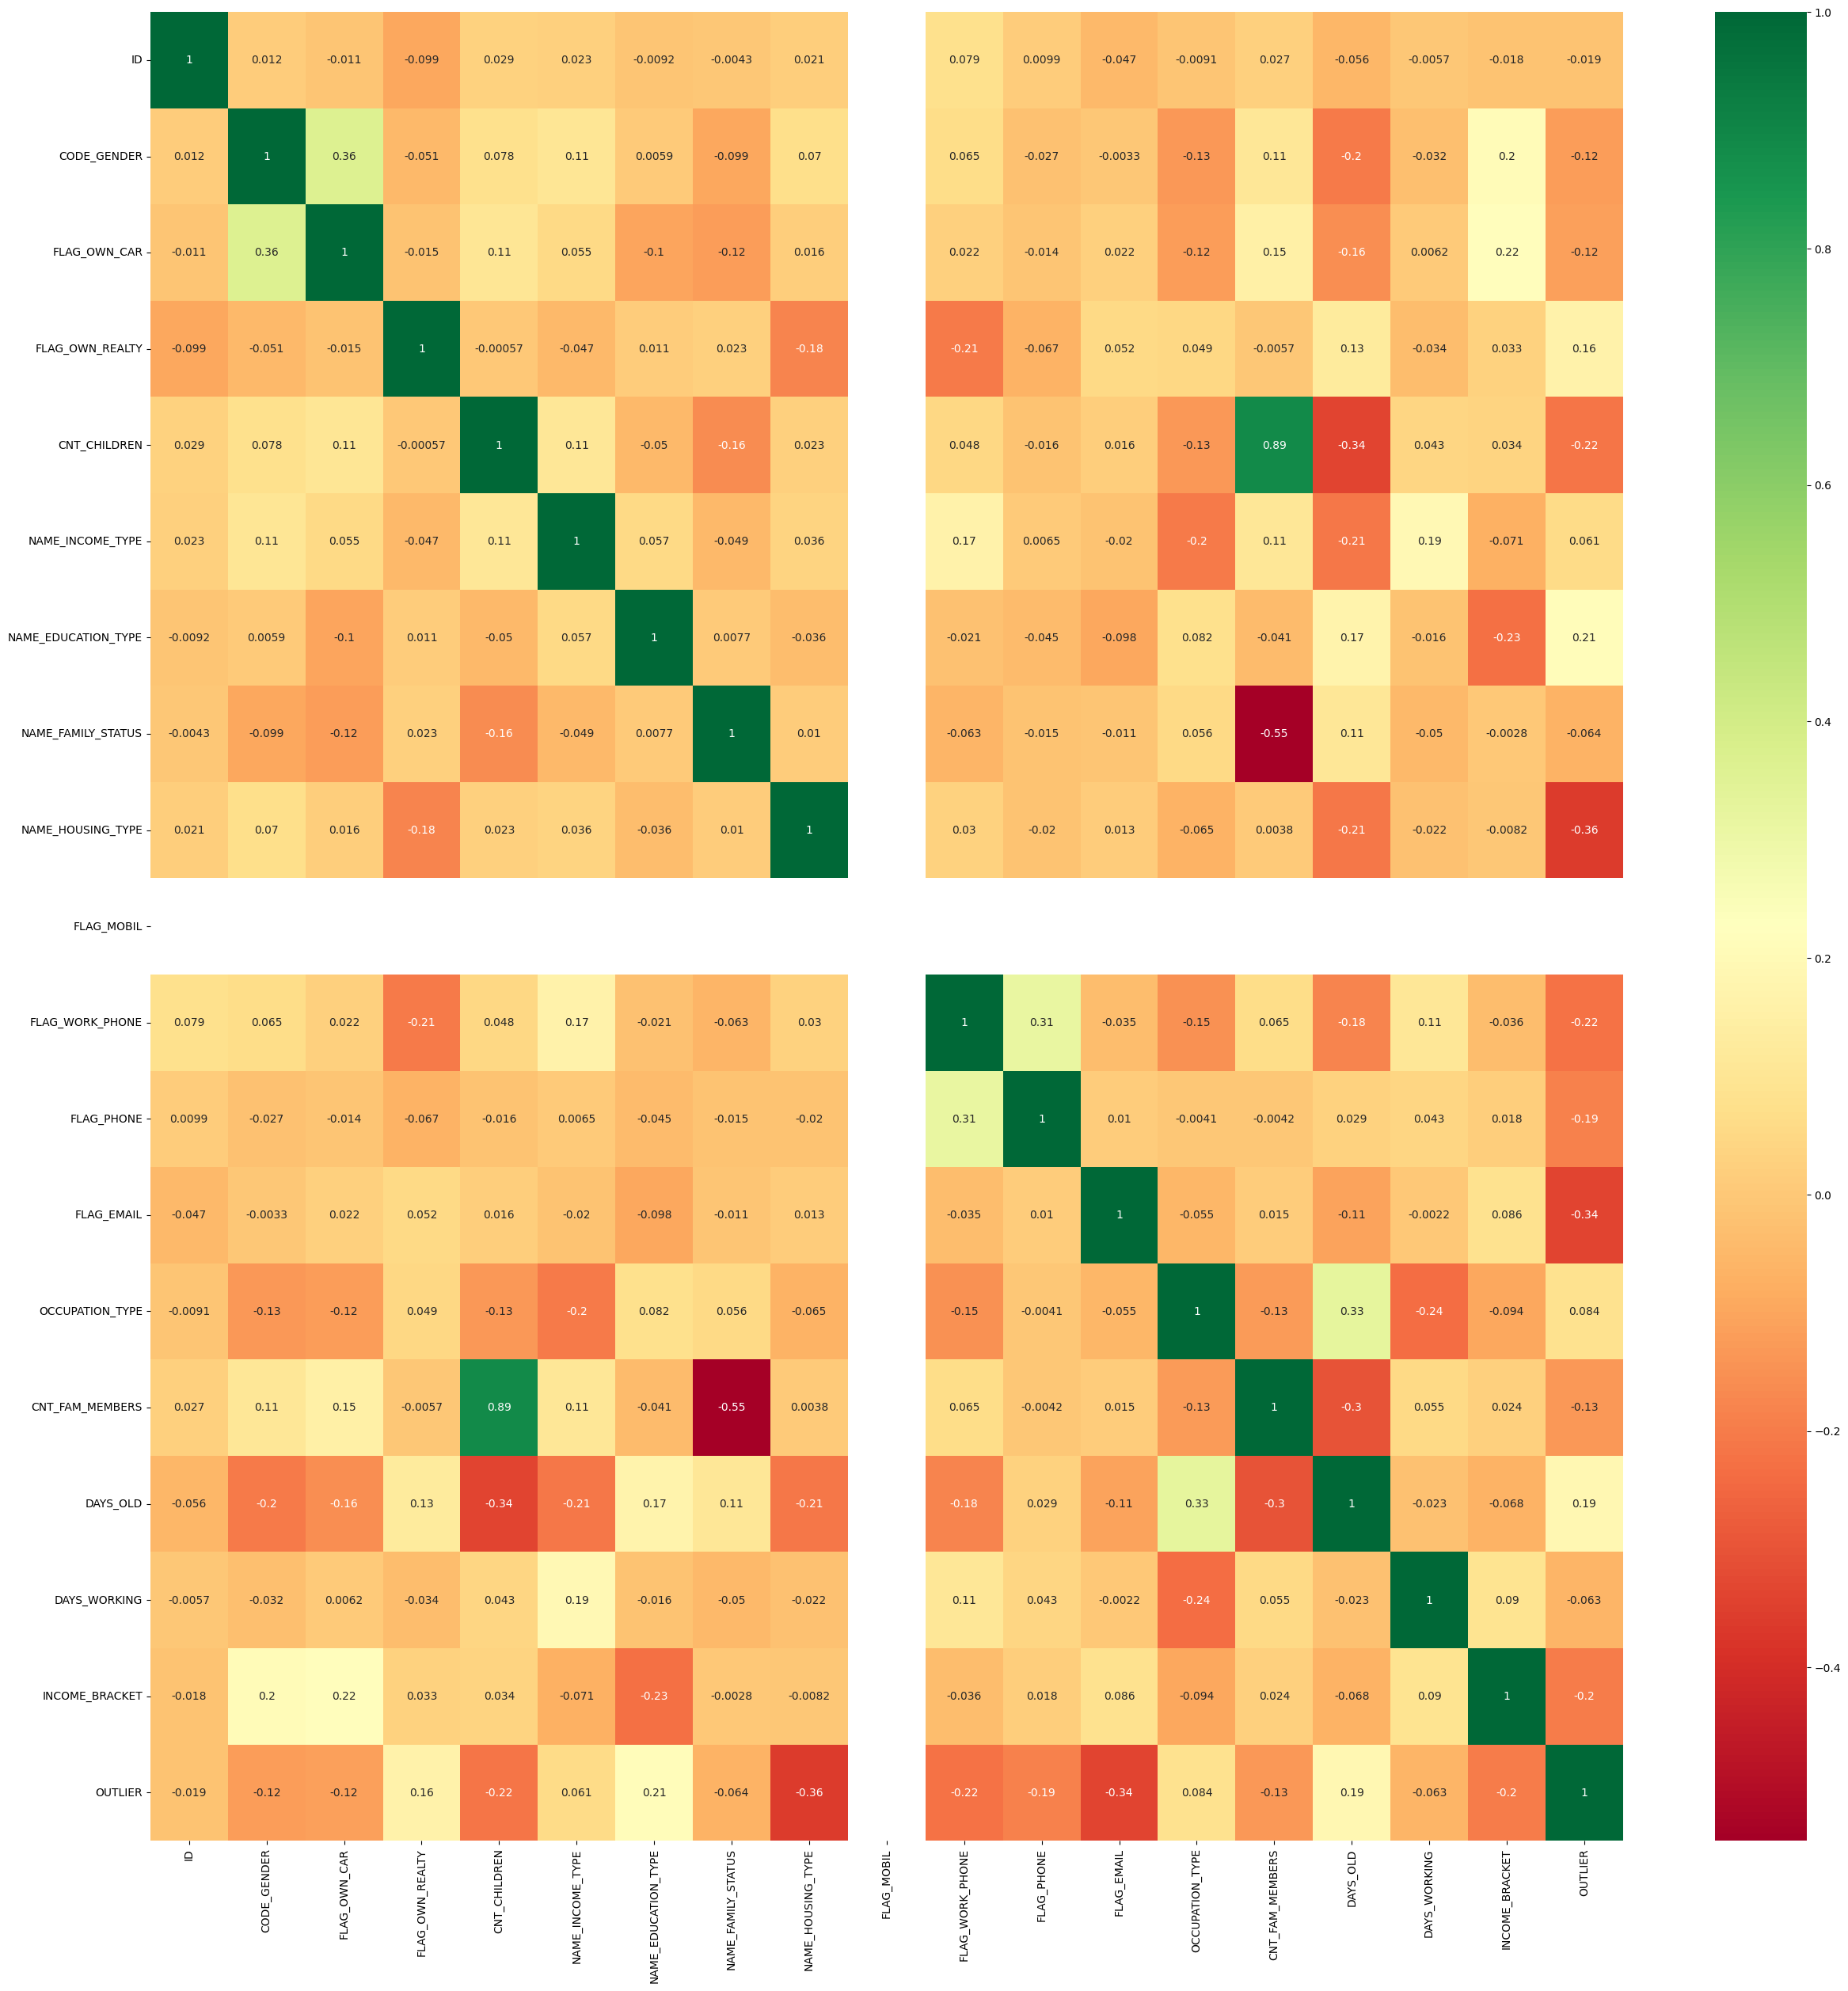

In [19]:
data = applications.copy()
data['OUTLIER'] = pred1
plt.figure(figsize=(30,30))
g=sns.heatmap(data.corr(),annot=True,cmap="RdYlGn")

In [20]:
c = data.corr()
c = abs(c['OUTLIER']).sort_values(ascending=False).drop(['OUTLIER','FLAG_MOBIL'])[:8]

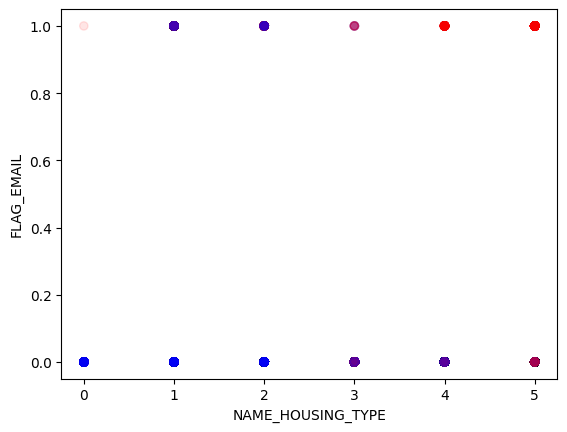

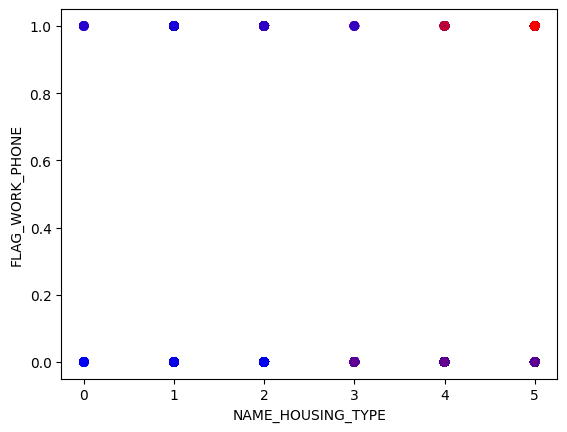

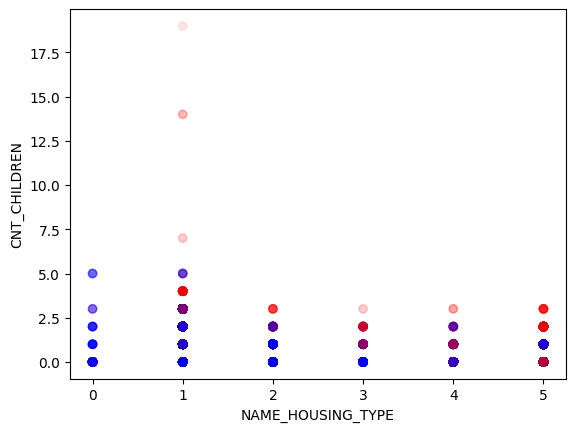

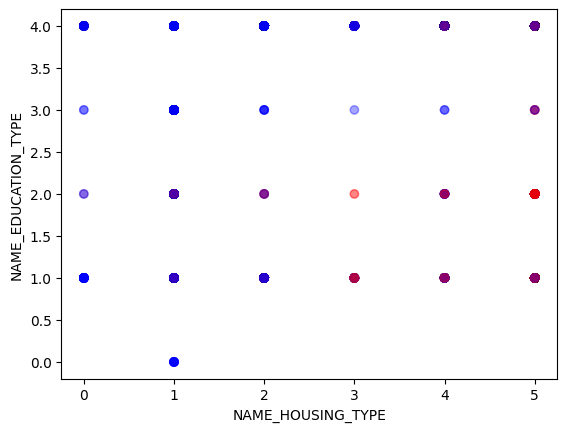

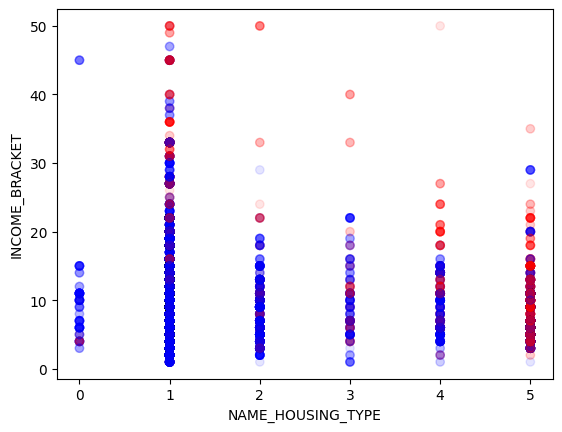

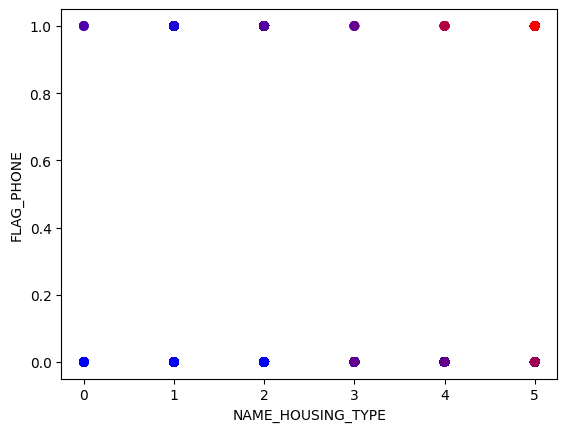

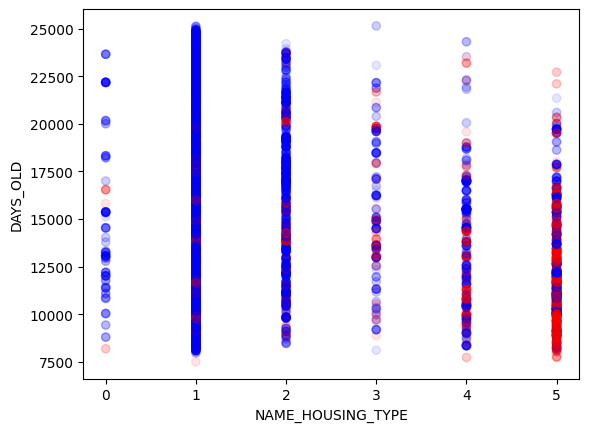

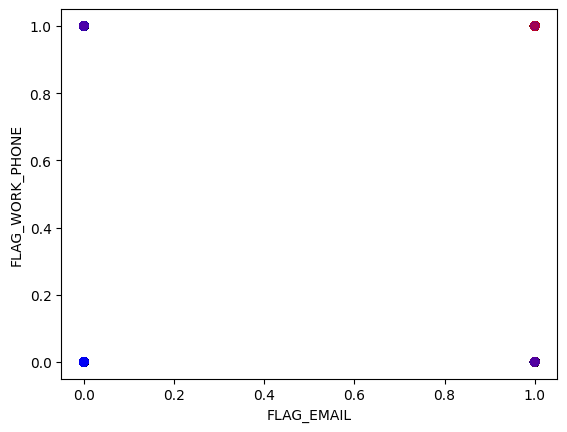

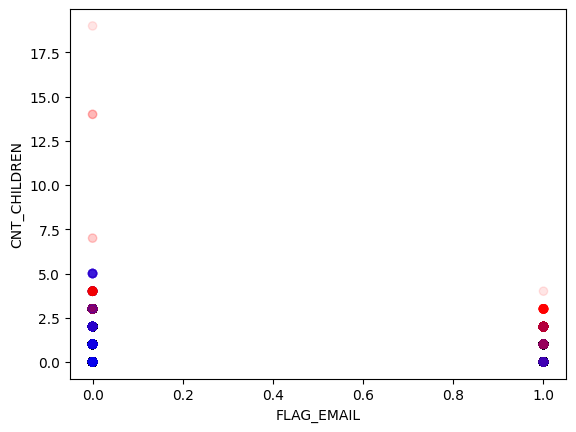

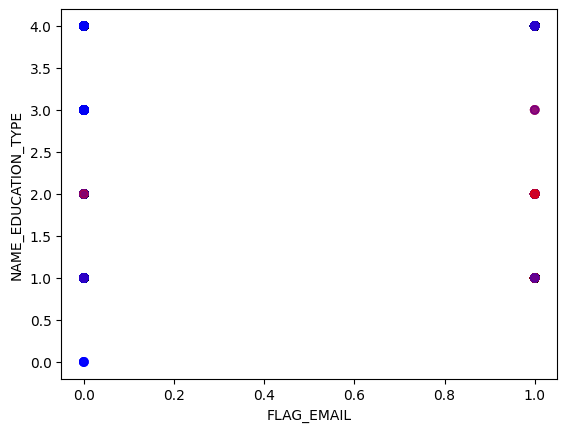

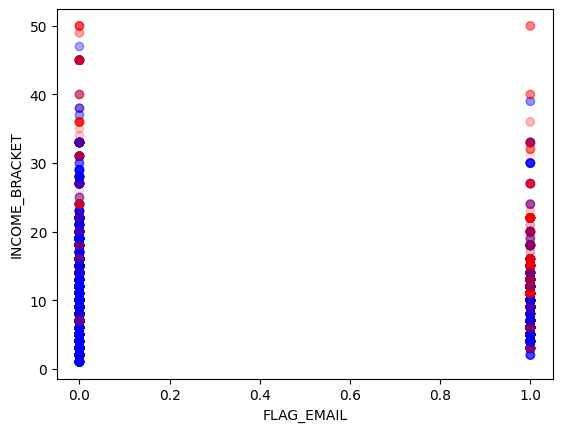

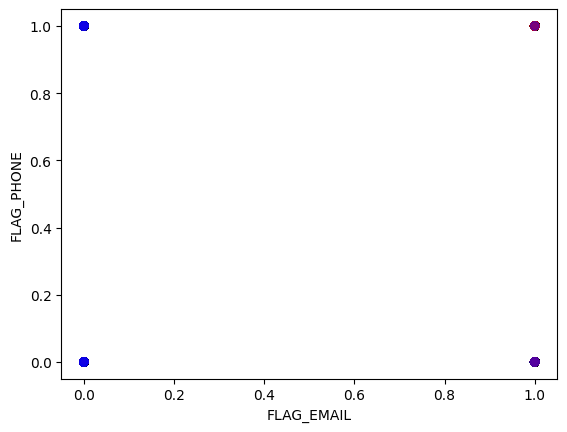

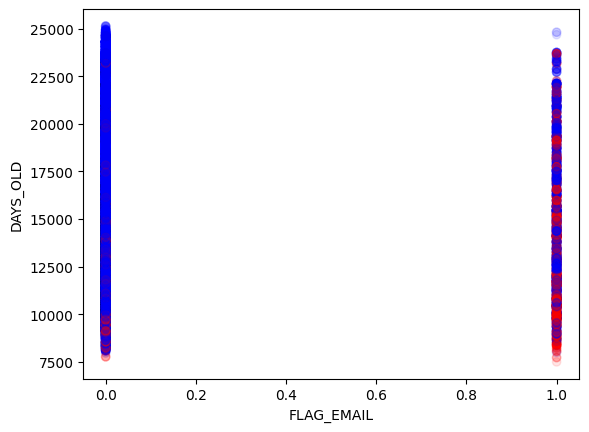

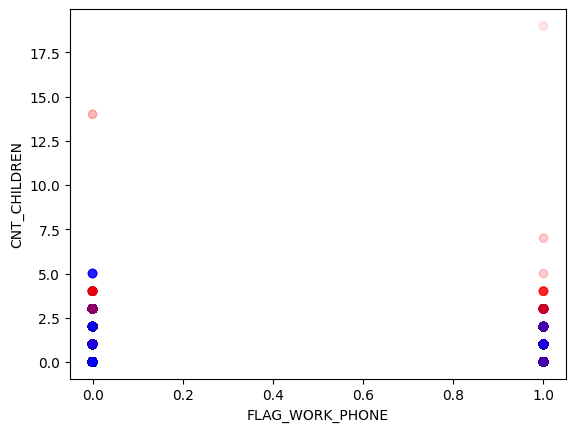

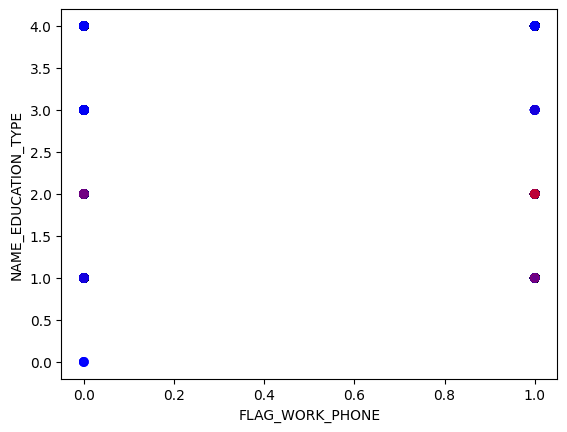

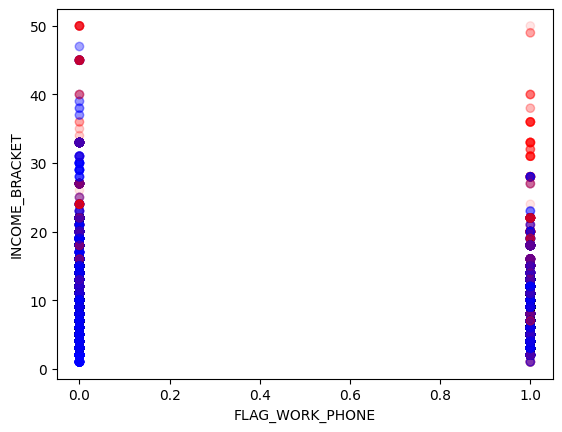

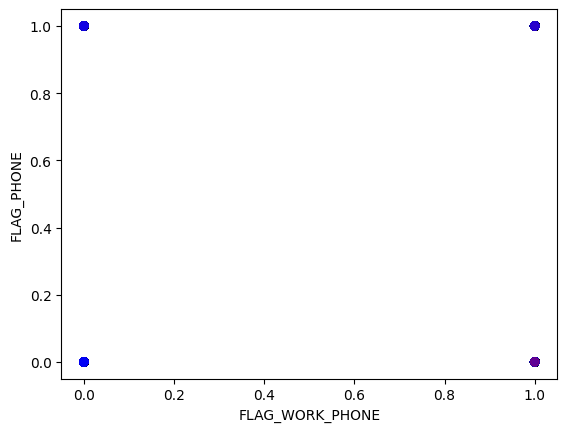

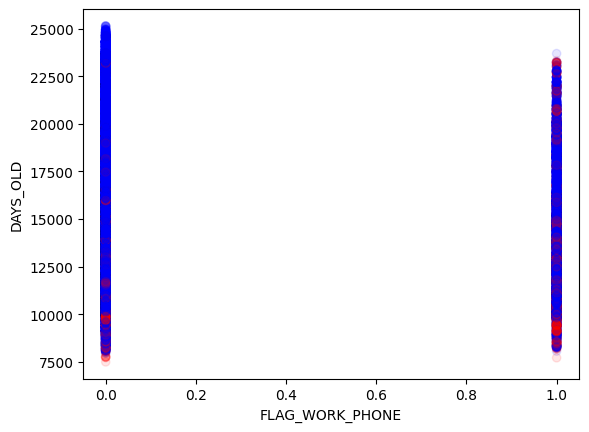

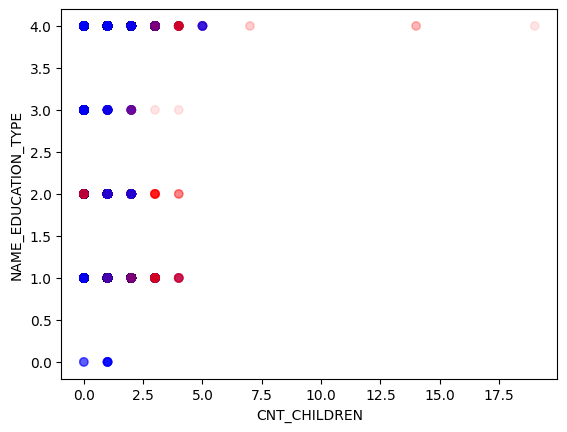

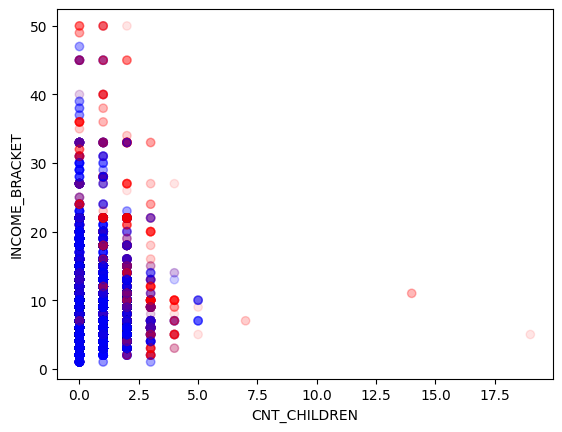

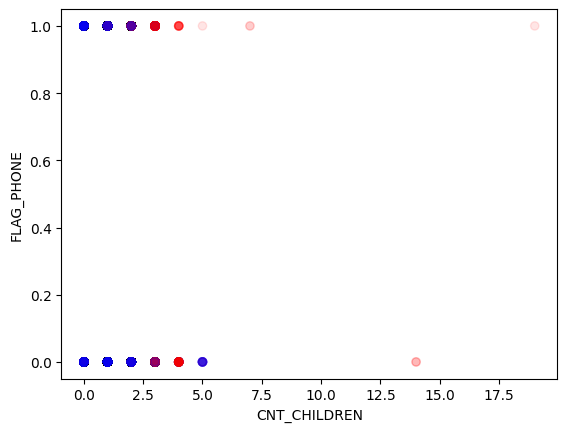

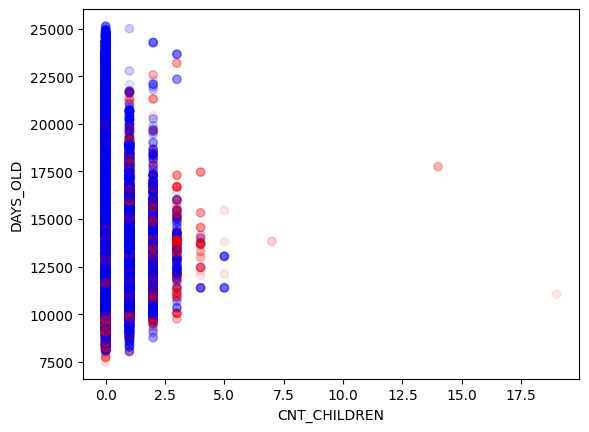

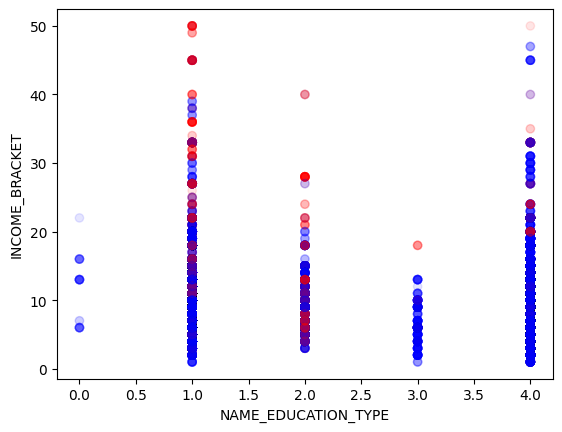

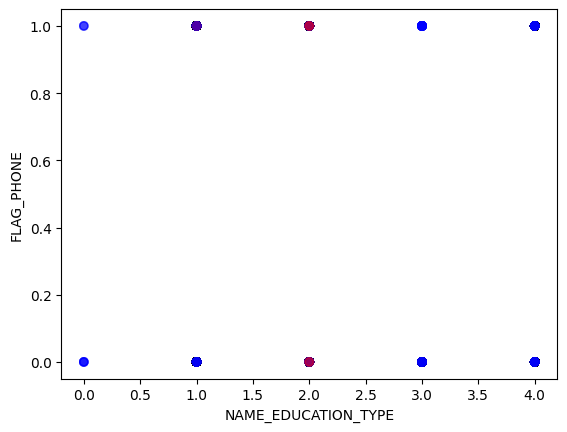

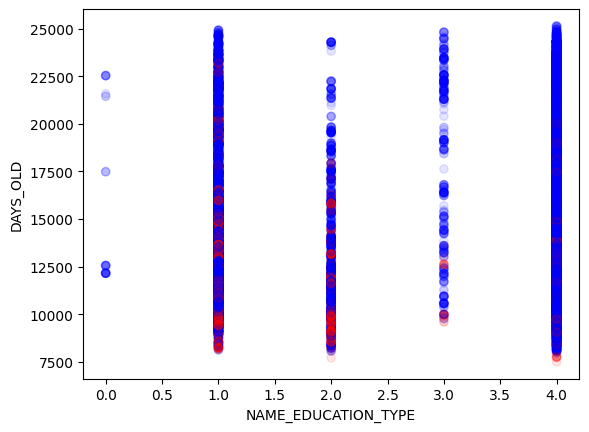

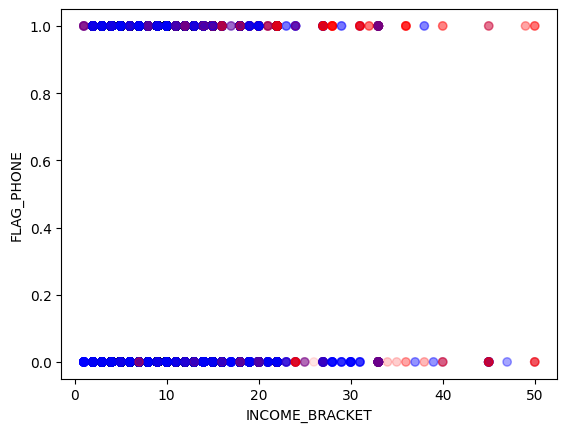

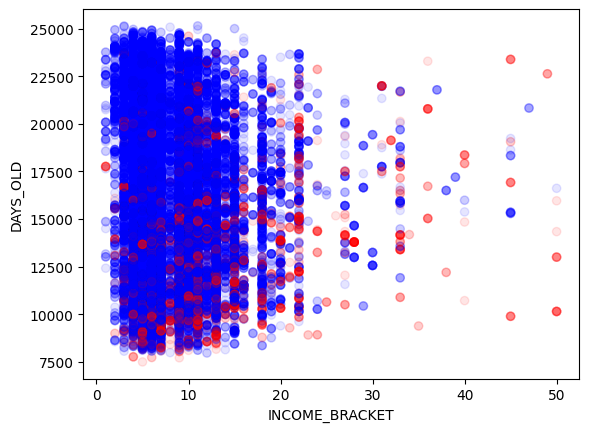

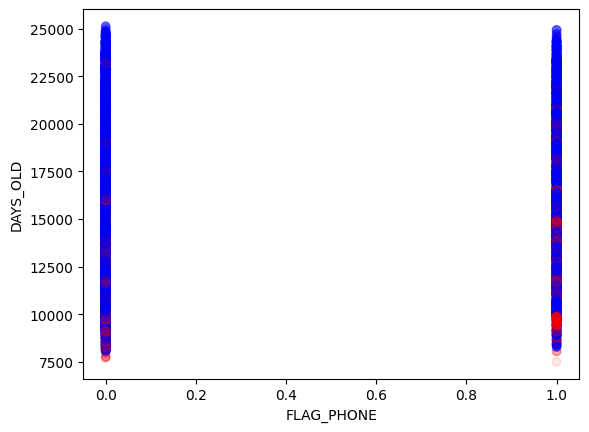

In [21]:
c_names = c.index.to_list()
for i in range(len(c_names)):
    for j in range(i+1,len(c_names)):
        plot_outliers_cols(data = applications, col1 = c_names[i], col2 = c_names[j], outliers = pred1)

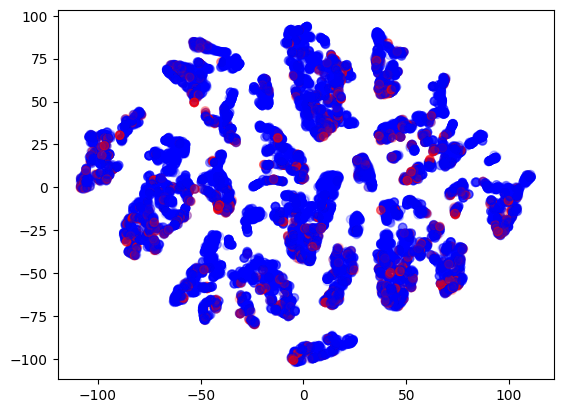

In [22]:
perplexities = [100] #[2,5,30,50,100]
for p in perplexities:
    tsne = TSNE(n_components=2, n_jobs=-1, perplexity=p)
    tsne_res = tsne.fit_transform(applications)
    tsne_res
    r_T = np.transpose(tsne_res)
    plot_outliers(r_T[0],r_T[1],pred1)

### Local Outlier Factor

In [23]:
lof = LOF(n_neighbors=30, n_jobs=-1)
pred2 = lof.fit_predict(applications)
c = (pred2<0).sum()
print("Outliers: ",c)

Outliers:  998


In [24]:
ind = []
for i in range(len(pred2)):
    if pred2[i] == -1:
        ind.append(i)
outliers = applications.iloc[ind]
outliers.describe()

ID  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
count  9.980000e+02   998.000000    998.000000       998.000000    998.000000   
mean   5.075809e+06     0.348697      0.343687         0.741483      0.256513   
std    4.479198e+04     0.476797      0.475176         0.438039      0.632085   
min    5.008806e+06     0.000000      0.000000         0.000000      0.000000   
25%    5.041261e+06     0.000000      0.000000         0.000000      0.000000   
50%    5.065643e+06     0.000000      0.000000         1.000000      0.000000   
75%    5.116099e+06     1.000000      1.000000         1.000000      0.000000   
max    5.150479e+06     1.000000      1.000000         1.000000      4.000000   

       NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
count        998.000000           998.000000          998.000000   
mean           2.259519             3.097194            1.441884   
std            1.738635             1.340508            1.044703   
min            0.000000             1.000000            0.000000   
25%            0.000000             1.000000            1.000000   
50%            2.000000             4.000000            1.000000   
75%            4.000000             4.000000            1.000000   
max            4.000000             4.000000            4.000000   

       NAME_HOUSING_TYPE  FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  \
count         998.000000       998.0       998.000000  998.000000  998.000000   
mean            1.208417         1.0         0.199399    0.271543    0.074148   
std             0.828679         0.0         0.399749    0.444978    0.262143   
min             0.000000         1.0         0.000000    0.000000    0.000000   
25%             1.000000         1.0         0.000000    0.000000    0.000000   
50%             1.000000         1.0         0.000000    0.000000    0.000000   
75%             1.000000         1.0         0.000000    1.000000    0.000000   
max             5.000000         1.0         1.000000    1.000000    1.000000   

       OCCUPATION_TYPE  CNT_FAM_MEMBERS      DAYS_OLD  DAYS_WORKING  \
count       998.000000       998.000000    998.000000    998.000000   
mean         11.142285         2.027054  18155.267535   2761.693387   
std           5.974855         0.811323   5038.966974   3150.135756   
min           0.000000         1.000000   7489.000000      0.000000   
25%           6.000000         2.000000  13648.000000    473.000000   
50%          11.000000         2.000000  19961.000000   1812.000000   
75%          18.000000         2.000000  22631.250000   3760.000000   
max          18.000000         6.000000  25099.000000  15661.000000   

       INCOME_BRACKET  
count      998.000000  
mean         9.527054  
std          6.818375  
min          1.000000  
25%          6.000000  
50%          8.000000  
75%         11.000000  
max         49.000000

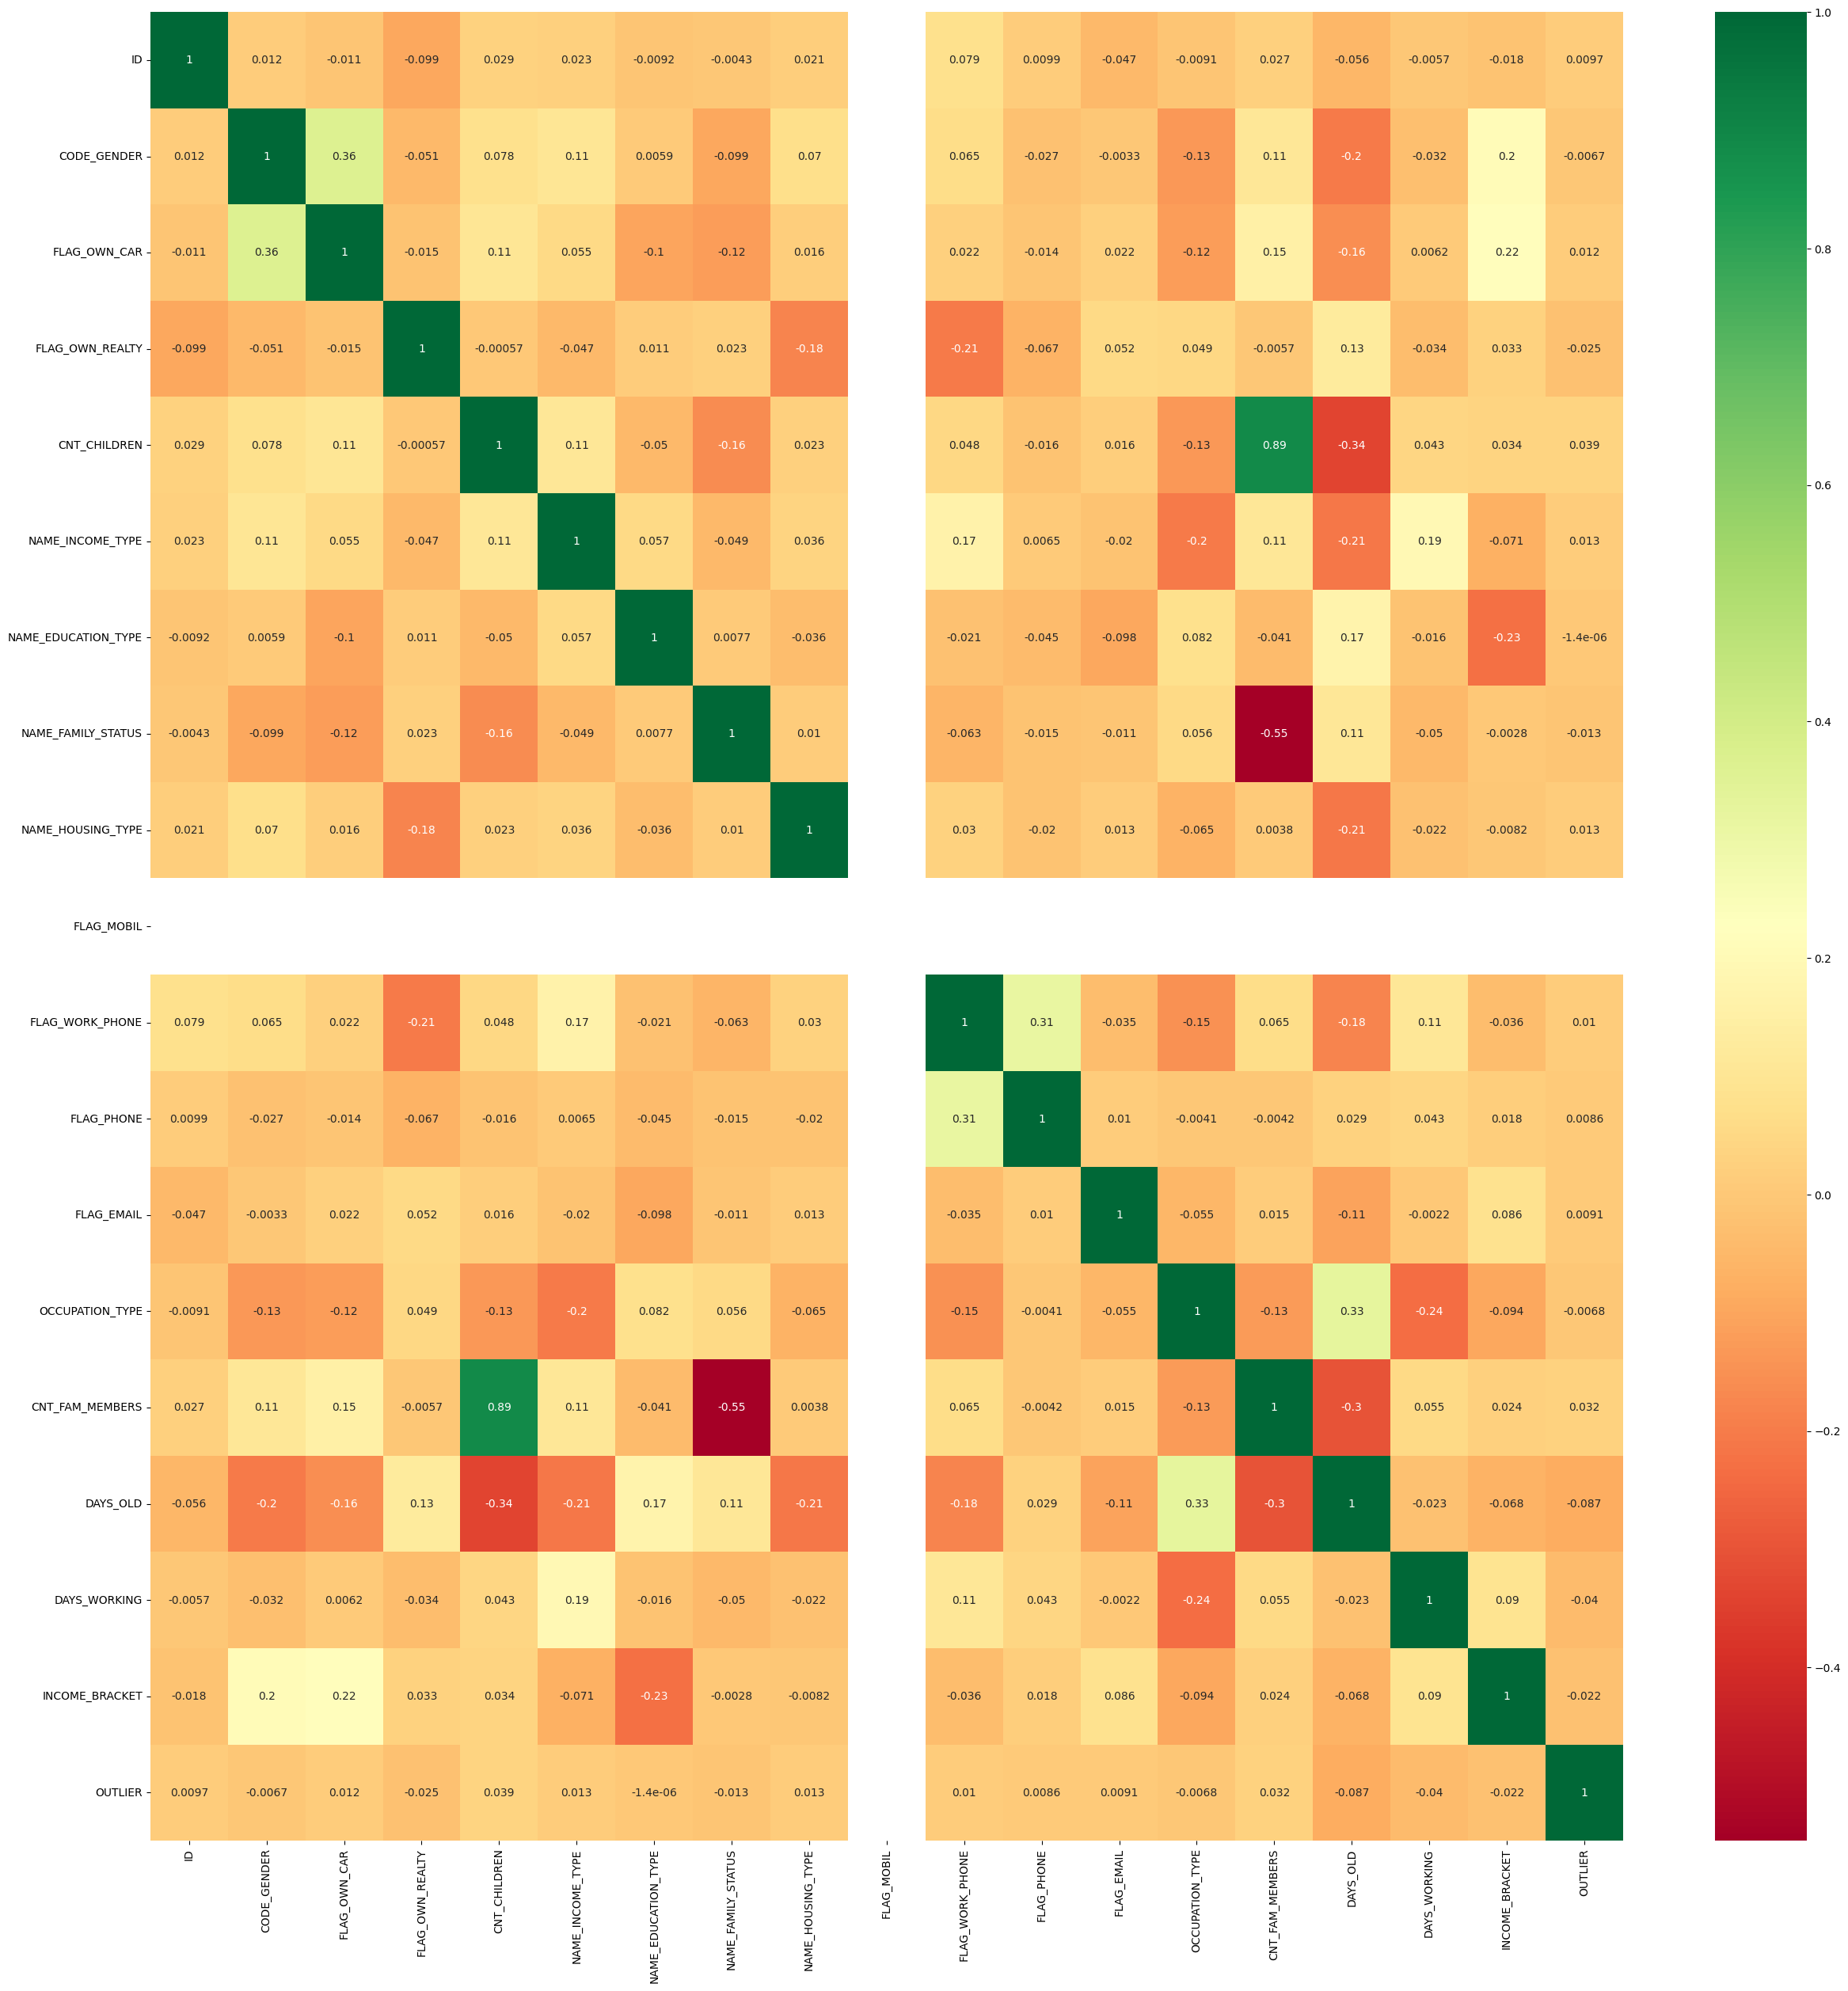

In [25]:
data = applications.copy()
data['OUTLIER'] = pred2
plt.figure(figsize=(30,30))
g=sns.heatmap(data.corr(),annot=True,cmap="RdYlGn")

In [26]:
c = data.corr()
c = abs(c['OUTLIER']).sort_values(ascending=False).drop(['OUTLIER','FLAG_MOBIL'])[:8]

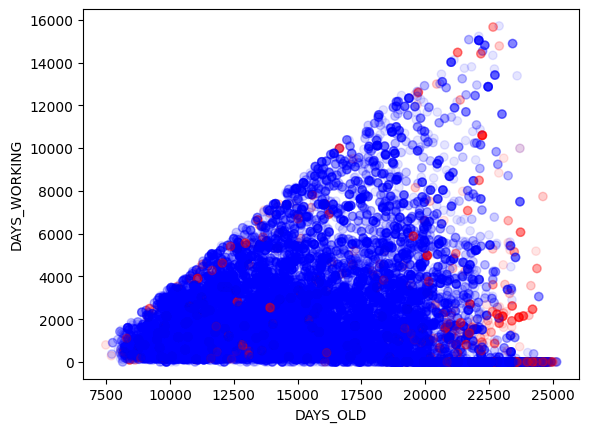

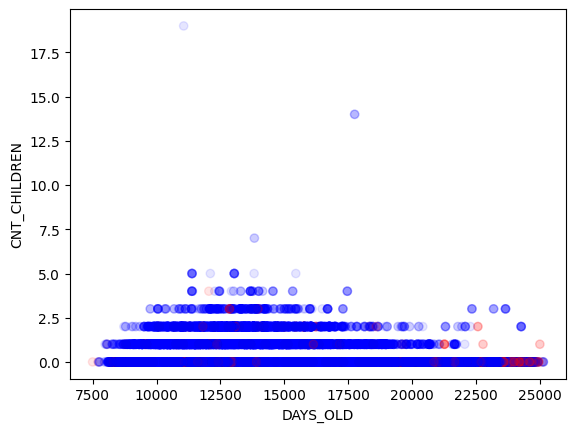

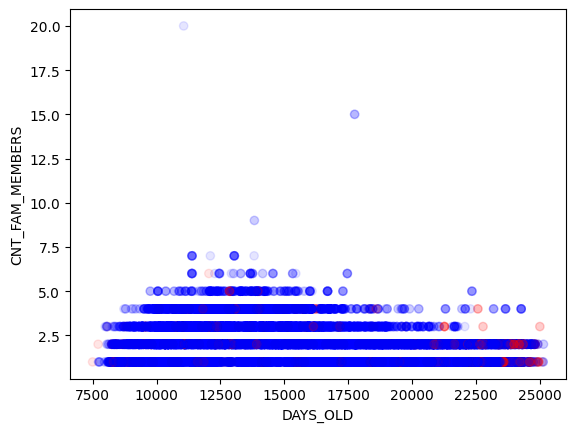

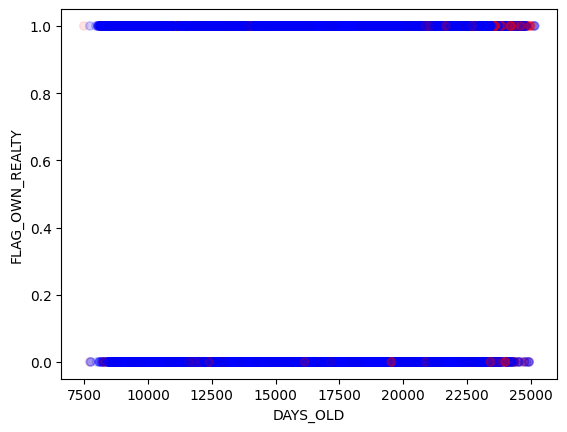

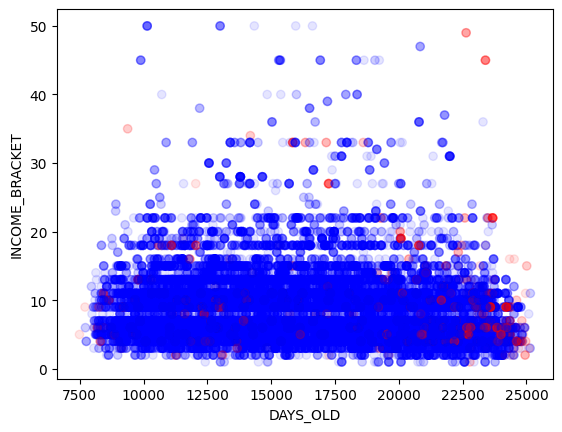

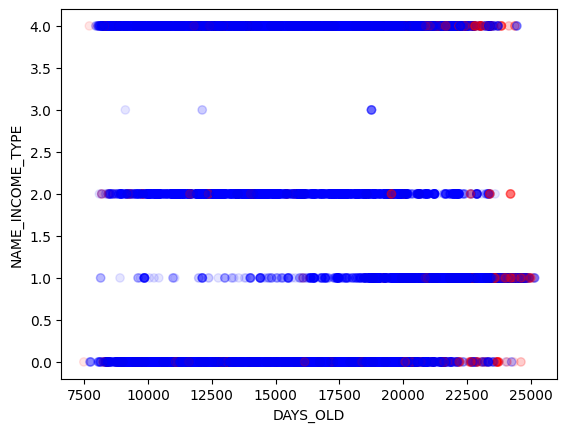

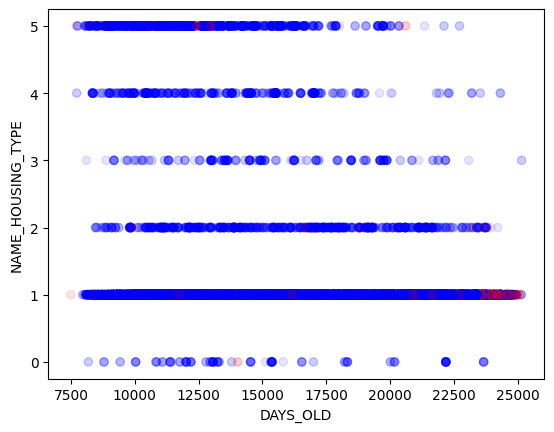

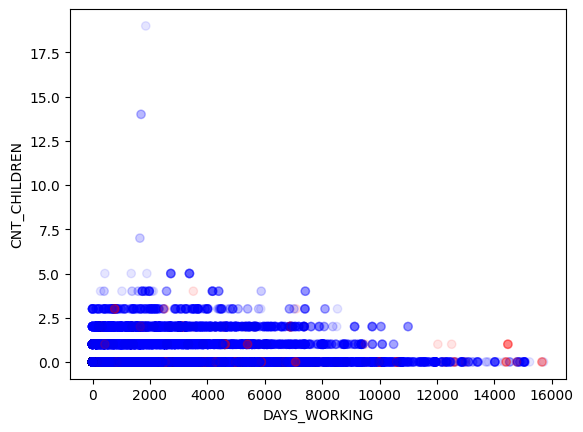

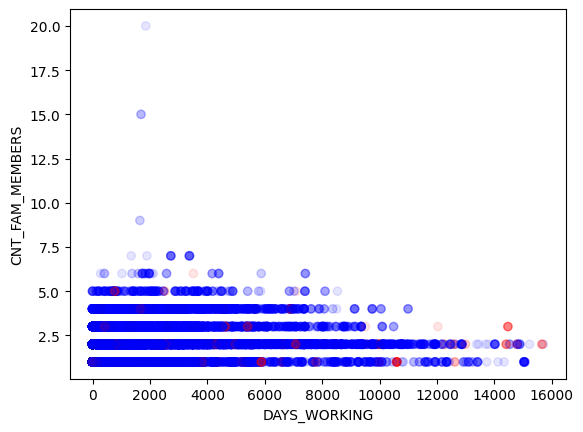

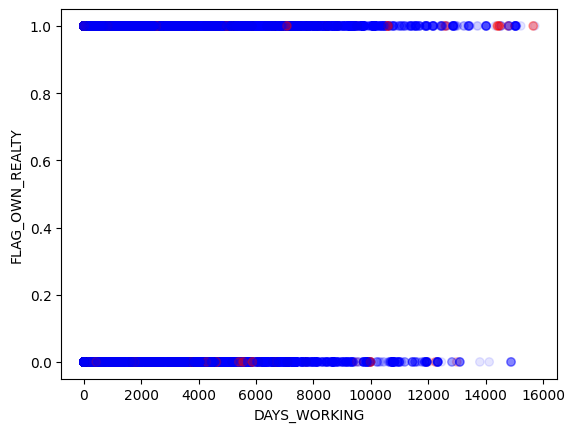

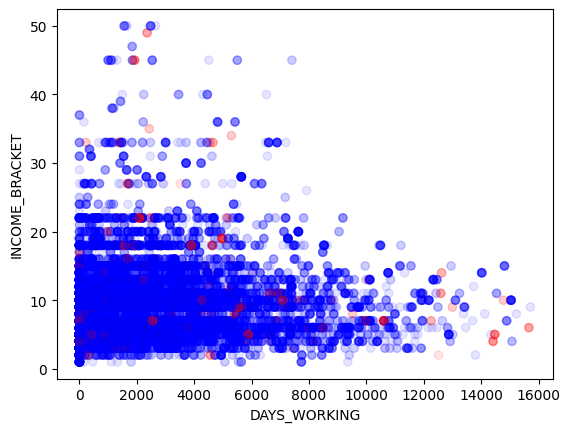

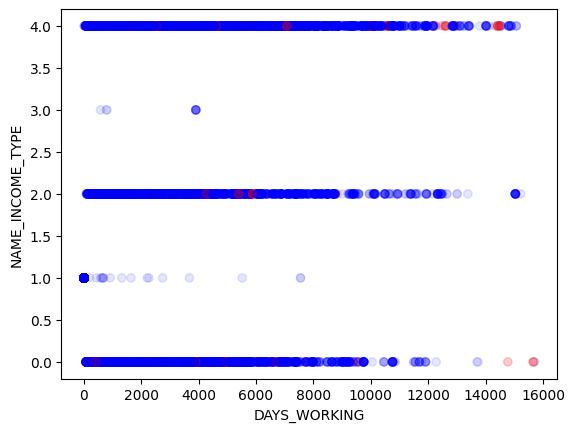

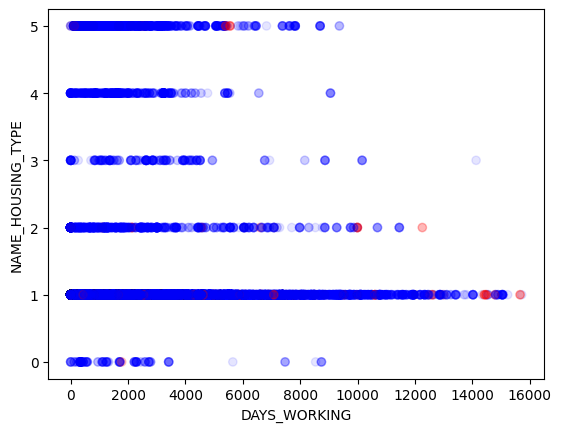

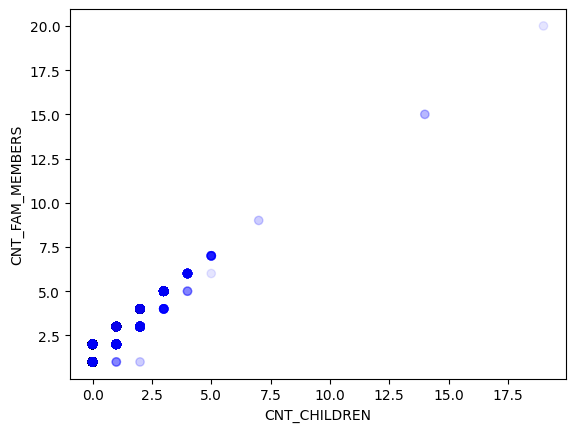

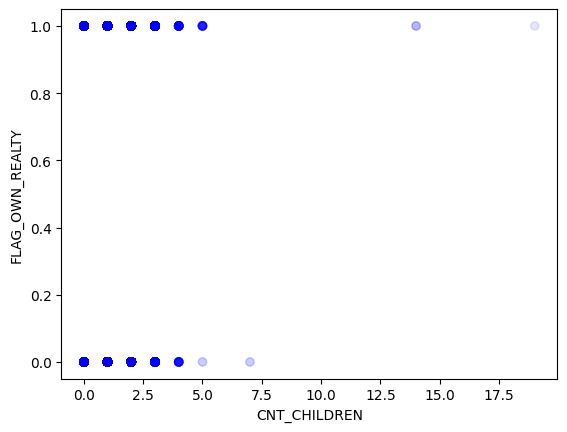

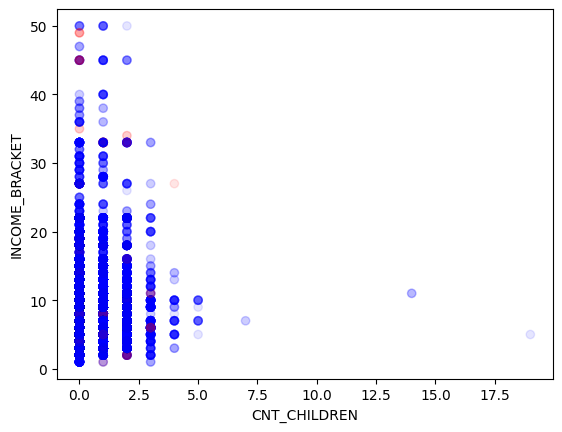

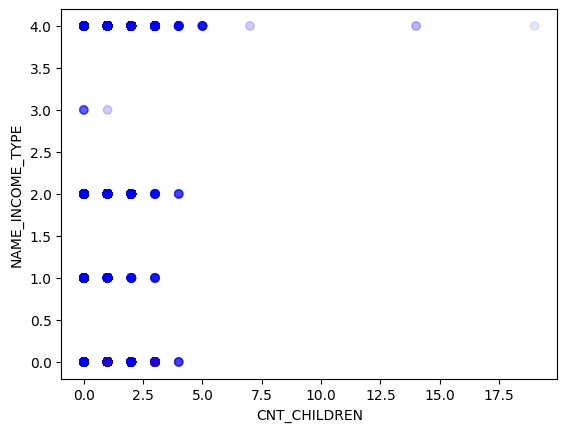

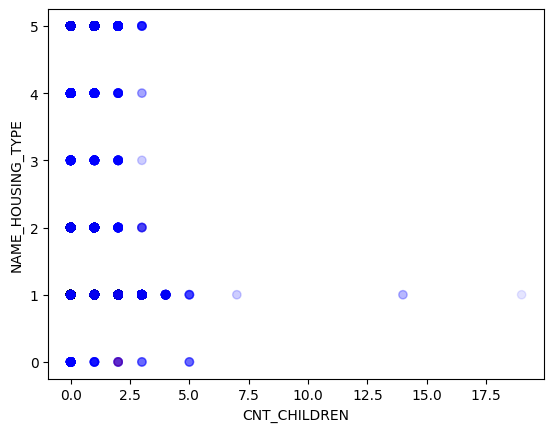

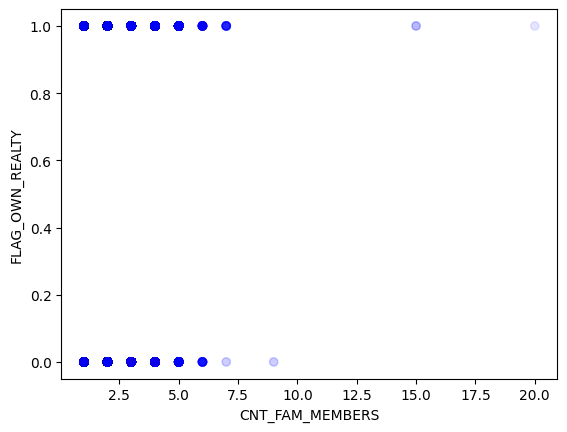

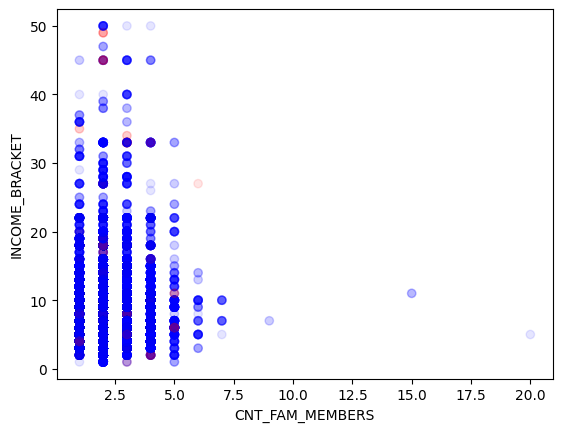

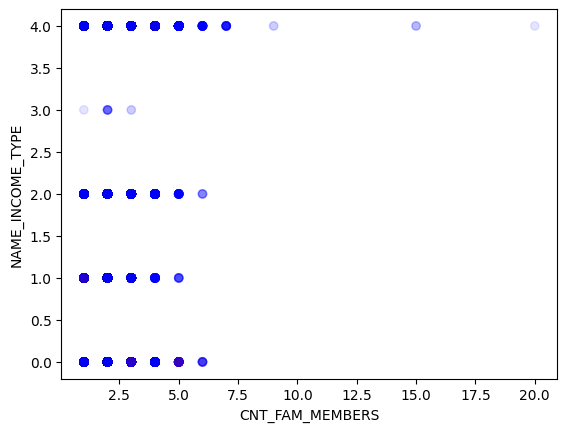

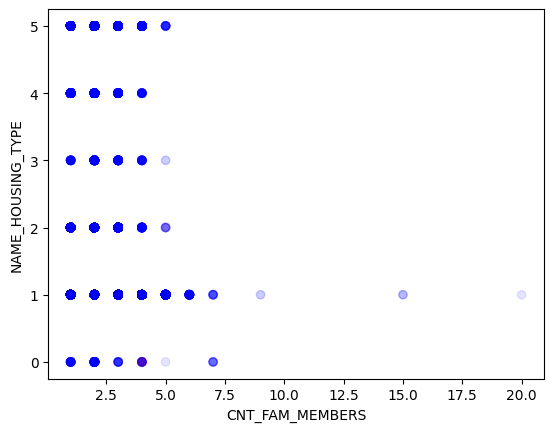

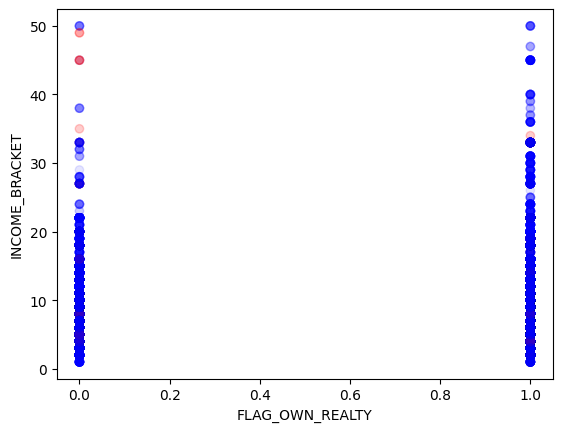

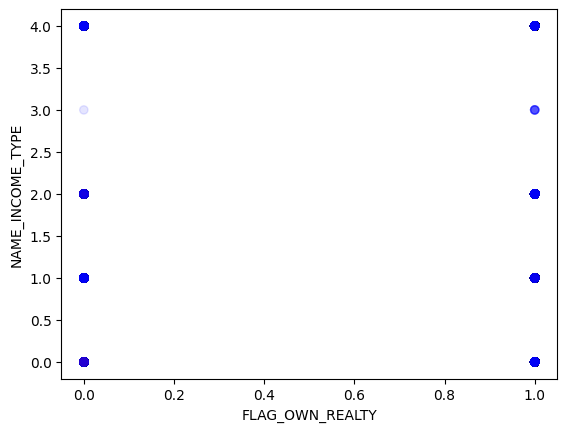

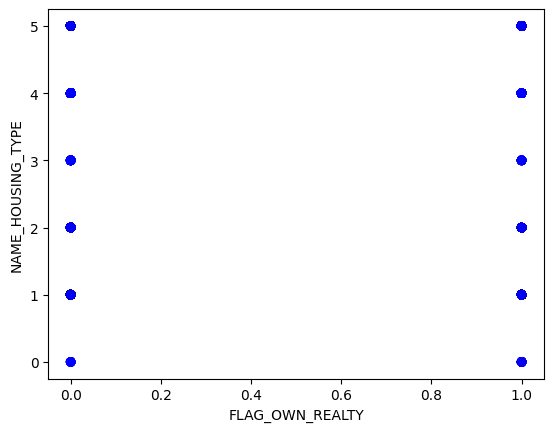

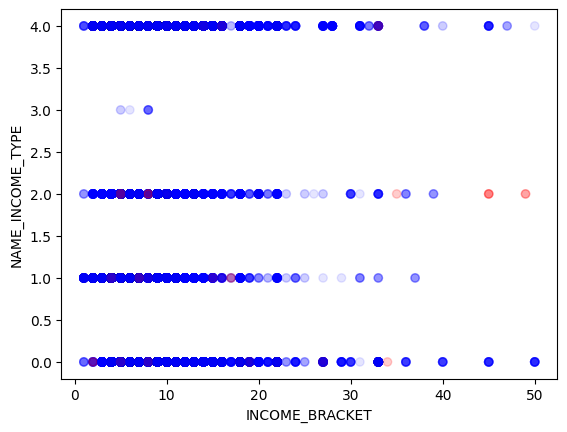

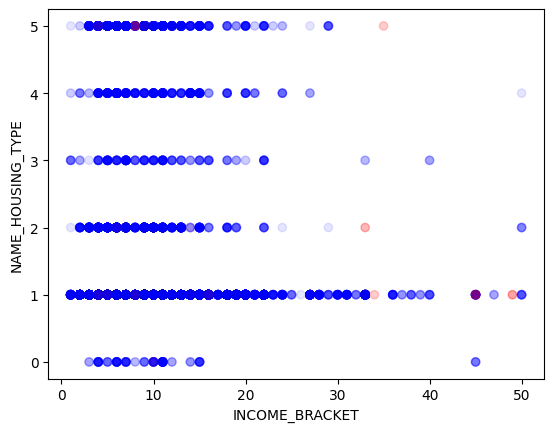

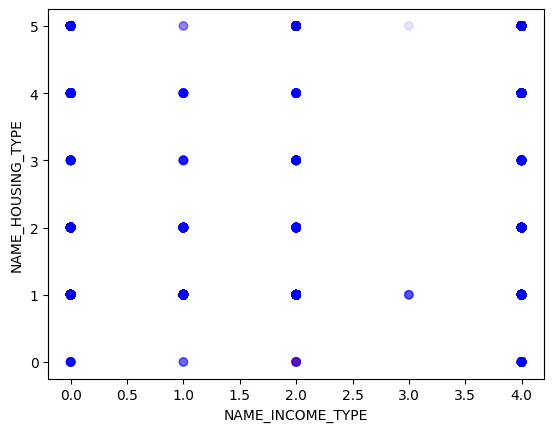

In [27]:
c_names = c.index.to_list()
for i in range(len(c_names)):
    for j in range(i+1,len(c_names)):
        plot_outliers_cols(applications, c_names[i], c_names[j], pred2)

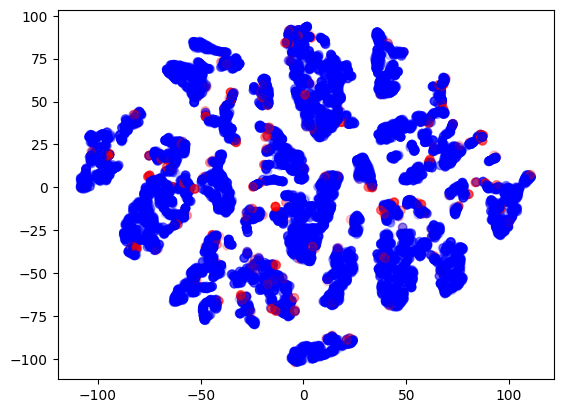

In [28]:
perplexities = [100] #[2,5,30,50,100]
for p in perplexities:
    tsne = TSNE(n_components=2, n_jobs=-1, perplexity=p)
    tsne_res = tsne.fit_transform(applications)
    tsne_res
    r_T = np.transpose(tsne_res)
    plot_outliers(r_T[0],r_T[1],pred2)

In [29]:
outliers=[]
for i in range(len(pred2)):
    if pred2[i]==-1:
        outliers.append(applications.index[i])
print("Outliers: ", len(outliers))
applications.drop(outliers, inplace=True)
applications

Outliers:  998


ID  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0       5008804            1             1                1             0   
1       5008805            1             1                1             0   
3       5008808            0             0                1             0   
4       5008809            0             0                1             0   
5       5008810            0             0                1             0   
...         ...          ...           ...              ...           ...   
434808  5149828            1             1                1             0   
434809  5149834            0             0                1             0   
434810  5149838            0             0                1             0   
434811  5150049            0             0                1             0   
434812  5150337            1             0                1             0   

        NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
0                      4                    1                   0   
1                      4                    1                   0   
3                      0                    4                   3   
4                      0                    4                   3   
5                      0                    4                   3   
...                  ...                  ...                 ...   
434808                 4                    4                   1   
434809                 0                    1                   1   
434810                 1                    1                   1   
434811                 4                    4                   1   
434812                 4                    4                   3   

        NAME_HOUSING_TYPE  FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  \
0                       4           1                1           0   
1                       4           1                1           0   
3                       1           1                0           1   
4                       1           1                0           1   
5                       1           1                0           1   
...                   ...         ...              ...         ...   
434808                  1           1                0           0   
434809                  1           1                0           1   
434810                  1           1                0           1   
434811                  1           1                0           0   
434812                  4           1                0           0   

        FLAG_EMAIL  OCCUPATION_TYPE  CNT_FAM_MEMBERS  DAYS_OLD  DAYS_WORKING  \
0                0               18              2.0     12005          4542   
1                0               18              2.0     12005          4542   
3                1               14              1.0     19110          3051   
4                1               14              1.0     19110          3051   
5                1               14              1.0     19110          3051   
...            ...              ...              ...       ...           ...   
434808           0               10              2.0     17348          2420   
434809           1               11              2.0     12387          1325   
434810           1               11              2.0     12387          1325   
434811           0               14              2.0     17958           655   
434812           0                8              1.0      9188          1193   

        INCOME_BRACKET  
0                 21.0  
1                 21.0  
3                 13.0  
4                 13.0  
5                 13.0  
...                ...  
434808            15.0  
434809             7.0  
434810             7.0  
434811            14.0  
434812             5.0  

[35459 rows x 18 columns]

## Prikaz

In [30]:
def plot_sub(data, axes, i, j, binwidth, color,title=None):
    m = np.mean(data)
    v = np.var(data)
    ax = get_ax(axes,i,j)

    sns.histplot(data = data, binwidth = binwidth, ax = ax, color=color, legend=False)
    
    ax.axvline(m, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {m:.2f}')
    ax.axvline(m - np.sqrt(v), color='green', linestyle='dashed', linewidth=2, label=f'-1 SD')
    ax.axvline(m + np.sqrt(v), color='green', linestyle='dashed', linewidth=2, label=f'+1 SD')

    if not title is None:
        ax.set_title(title)

def plot_pie(data, ax,col):
    labels = data.unique()
    counts = data.value_counts()
    ax.pie(counts,labels=labels,autopct='%1.1f%%')
    ax.set_title(col)

def get_ax(axes, i, j):
    if not hasattr(axes,'shape'):
        return axes
    elif len(axes.shape) == 1:
        return axes[i]
    else:
        return axes[i,j]
    
def get_plot_w_h(plot_count):
    w = int(plot_count**0.5)
    h = plot_count //w
    if plot_count%w !=0:
        h+=1
    return w,h

def plot_features(X, col_list, plot_w, plot_h):
    #col_list - kolona, sirina binova, boja
    plot_count = len(col_list)
    w,h = get_plot_w_h(plot_count)
    fig, axes = plt.subplots(h, w, figsize = (plot_h,plot_w))
    
    for i in range(h):
        for j in range(w):
            ind = i*w + j
            if ind >= plot_count:
                break
            col, bins, color = col_list[ind]
            plot_sub(X[col], axes, i, j, bins, color)
    plt.tight_layout()
    plt.show()

def plot_pie_charts(X, col_list, plot_w, plot_h):
    plot_count = len(col_list)
    w,h = get_plot_w_h(plot_count)
    fig, axes = plt.subplots(h, w, figsize = (plot_h,plot_w))
    
    for i in range(h):
        for j in range(w):
            ind = i*w + j
            if ind >= plot_count:
                break
            col = col_list[ind]
            plot_pie(X[col], get_ax(axes, i, j),col)
    plt.tight_layout()
    plt.show()

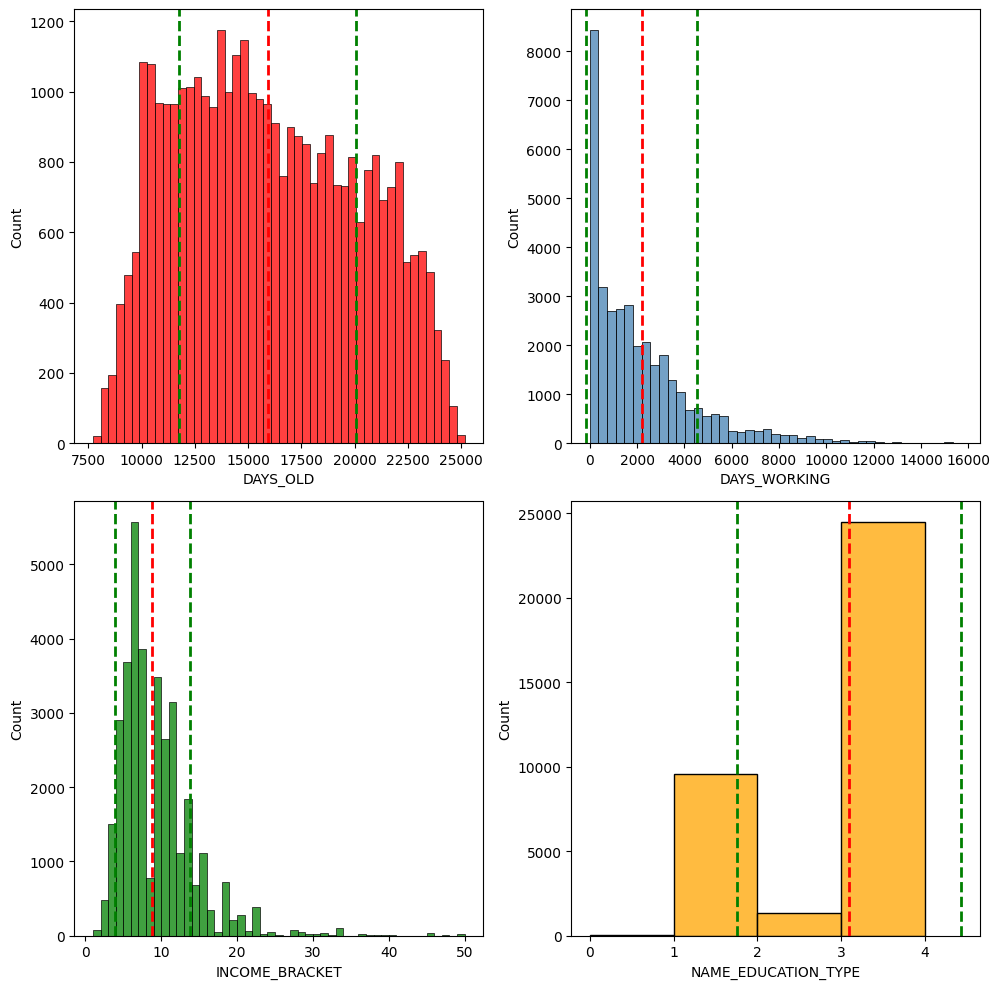

In [31]:
col_list = [('DAYS_OLD',365,'red'),\
            ('DAYS_WORKING',365,'steelblue'),\
            ('INCOME_BRACKET',1,'green'),\
            ('NAME_EDUCATION_TYPE',1,'orange')]
plot_features(applications,col_list,10,10)

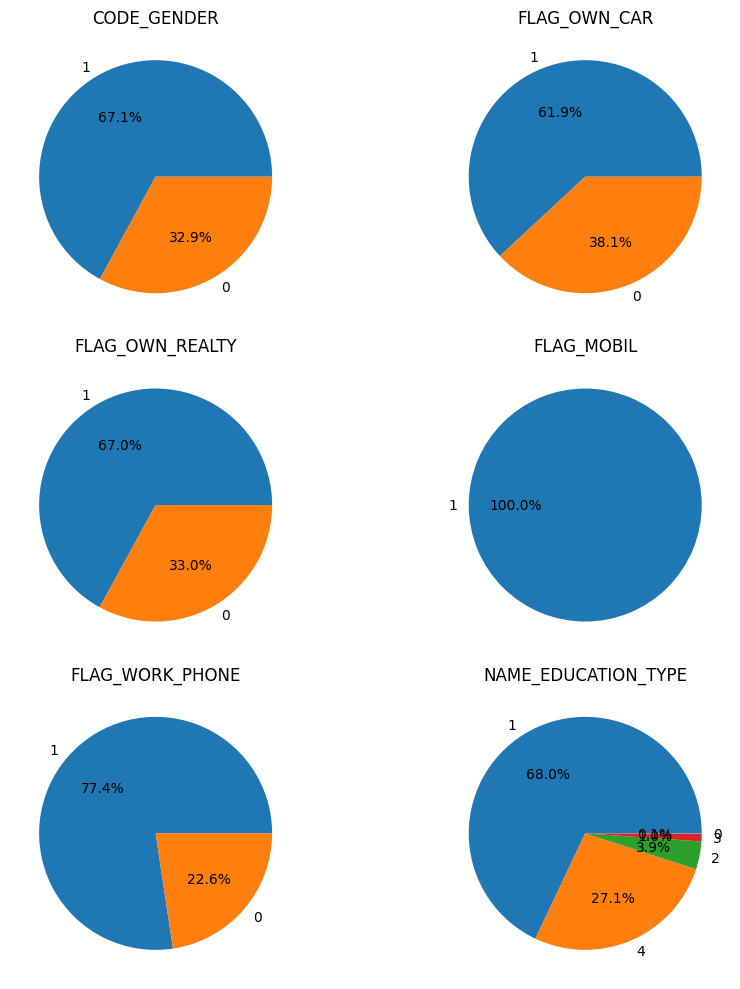

In [32]:
col_list = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','FLAG_MOBIL','FLAG_WORK_PHONE','NAME_EDUCATION_TYPE']
plot_pie_charts(applications,col_list,10,10)

# Odredjivanje grupe korisnika

In [33]:
# #Nadjemo istoriju placanje za one korisnike ciji ID je u obe tabele
# payment_history = cred_enc[cred_enc['ID'].isin(applications['ID'])]
# #Za svakog korisnika nadjemo status otplate za svaki od meseca, sortiramo i uzmemo samo najnovije podatke
# last_pay_dict = payment_history.groupby('ID').apply(lambda x: sorted(zip(x['MONTHS_BALANCE'], x['STATUS']),reverse=True)[0][1]).to_dict()
# avg_pay_dict = payment_history.groupby('ID').apply(lambda x: sorted(zip(x['MONTHS_BALANCE'], x['STATUS']),reverse=True)).to_dict()

In [34]:
# def get_avg_pay(pay_dict):
#     for i in pay_dict.keys():
#         l = pay_dict[i]
#         tot_w = 0
#         s = 0
#         for j in range(len(l)):
#             w = 1/(j+1)
#             s += w * l[j][1]
#             tot_w += w
#         pay_dict[i] = int(s / tot_w)
#     return pay_dict
# avg = list(get_avg_pay(avg_pay_dict).values())
# last = list(last_pay_dict.values())

In [35]:
# ids = list(last_pay_dict.keys())

In [36]:
# apps_with_paydata = applications[applications['ID'].isin(ids)]

## Skaliranje

In [37]:
# ss = StandardScaler()
# applications = ss.fit_transform(applications)

# Redukcija dimenzionalnosti

- DimReduction(tip, broj komp ili ne) -> Clustering (HDBSCAN, KMeans, Agllomerative) -> Viz
    - PCA - 0.95 variance
    - LLE - Tuneuj neighbors i components
    - Bez iceg
- Clustering
    - KMeans - silhoutte graph
    - HDBSCAN 
    - Agglomerative
- Viz
    - TSNE 2d

In [38]:
def get_pcas(min_comp, max_comp, step, out):
    i = min_comp
    while i<=max_comp:
        out.append(("PCA "+str(i)+" variance",PCA(n_components=i)))
        i+=step

def get_lles(min_comp, max_comp, step, min_neigh, max_neigh, neigh_step,out):
    for i in range(min_comp,max_comp,step):
        for j in range(min_neigh, max_neigh,step):
            out.append(("LLE "+str(i)+" components, "+str(j)+" neighbors",LocallyLinearEmbedding(n_components=i, n_jobs=-1, n_neighbors=j, eigen_solver='dense')))

def get_ag(min_cluster, max_cluster, step, out):
    for i in range(min_cluster,max_cluster,step):
        out.append(("AG "+str(i)+" clusters",AgglomerativeClustering(n_clusters=i)))

def plot_clusters(X, y, target, title):
    color_map = {0: 'darkblue', 1: 'red', 2: 'green', 3: 'yellow', 4:'skyblue', 5:'darkorchid', 6:'pink', 7:'lime',8:'black',9:'chocolate'}
    #colors = [color_map[i] for i in target]
    plt.title(title)
    plt.scatter(X, y, c=target, alpha=0.1)
    plt.show()

def visualize_tsne_clust(data, targets, title):
    perplexities = [100] #[2,5,30,50,100]
    for p in perplexities:
        tsne = TSNE(n_components=2, n_jobs=-1, perplexity=p)
        tsne_res = tsne.fit_transform(data)
        r_T = np.transpose(tsne_res)
        plot_clusters(r_T[0],r_T[1],targets, title)

def get_hdbscan(out):
    out.append(("HDBSCAN", HDBSCAN()))

def get_kmeans(min_cluster, max_cluster, step, out):
    for i in range(min_cluster,max_cluster,step):
        out.append(("KMeans "+str(i)+" clusters",KMeans(n_clusters=i)))

def plot_dict(x, y):
    plt.plot(x, y)
    plt.show()


## Kmeans

In [39]:
dims = PCA(n_components=0.95)

kmeans = [(x,KMeans(n_clusters=x)) for x in range(3,10,1)]
ag = [(x,AgglomerativeClustering(n_clusters=x)) for x in range(3,10,1)]
hdb = HDBSCAN()

rez_silh = {'km':[],'ag':[],'hdb':[]}

tsne = TSNE(n_components=2, n_jobs=-1, perplexity=p)
tsne_res = tsne.fit_transform(applications)
r_T = np.transpose(tsne_res)

x_vals = [x for x in range(3,10,1)]

KMeans


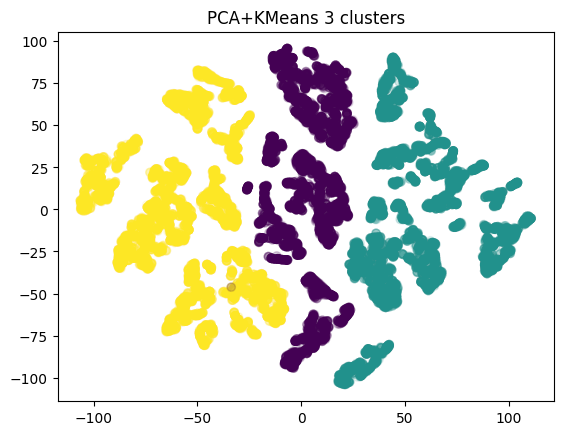

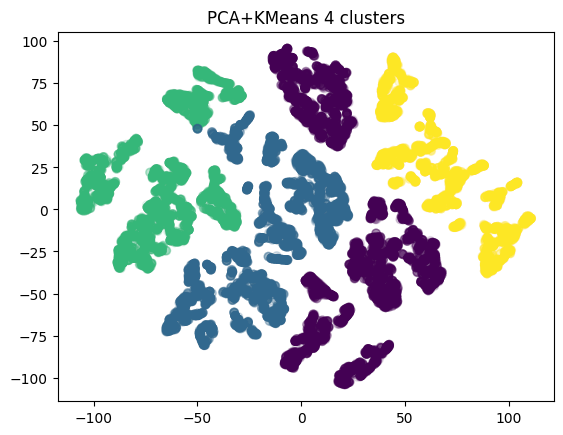

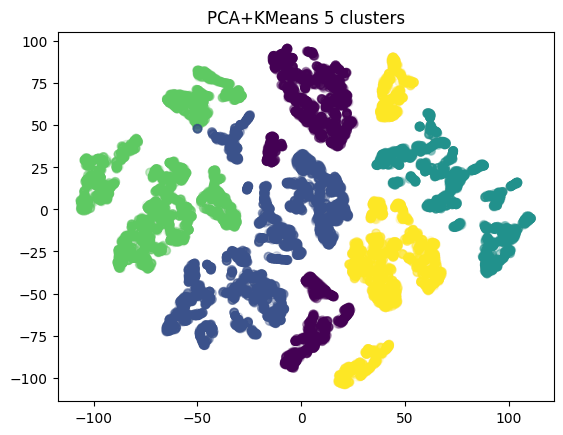

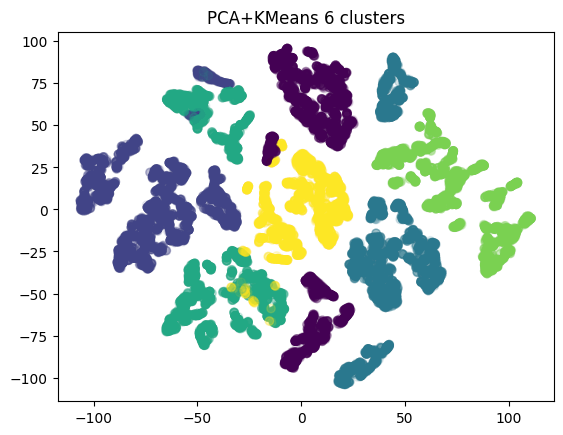

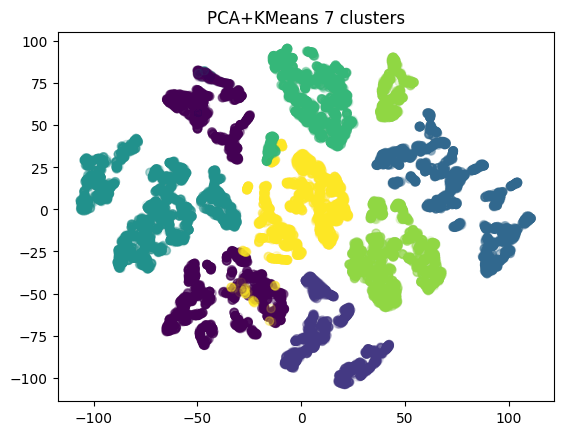

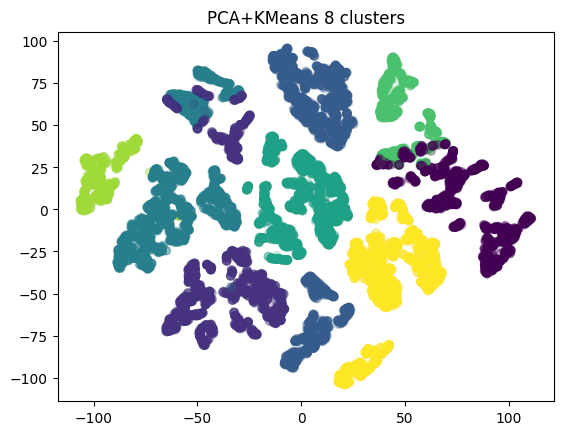

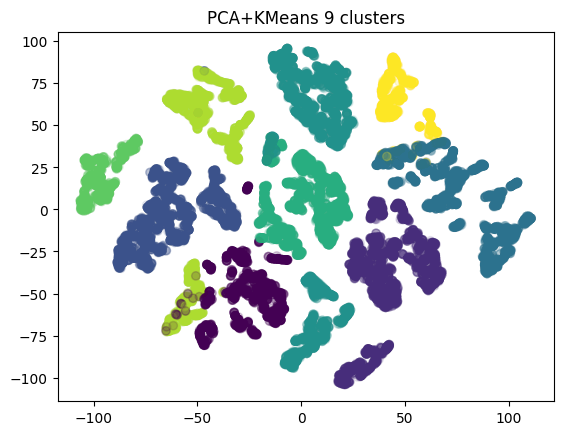

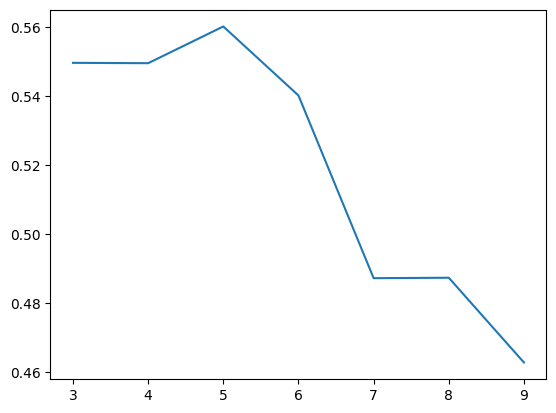

In [40]:
red_data = dims.fit_transform(applications)
rez_silh['km']=[]
rez_km = {0:[],1:[],2:[],3:[],4:[]}
print("KMeans")
for (i,k) in kmeans:
    clusters = k.fit_predict(red_data)
    if i==5:
        for c in range(len(clusters)):
            rez_km[clusters[c]].append(applications.iloc[c]['ID'])
    rez_silh['km'].append(silhouette_score(applications,clusters))
    plot_clusters(r_T[0],r_T[1],clusters,"PCA+KMeans "+str(i)+" clusters")
plot_dict(x_vals, rez_silh['km'])

In [41]:
id_to_balance = {}
for x in range(len(payment_history)):
    id = payment_history.iloc[x]['ID']
    balance = payment_history.iloc[x]['STATUS']
    if id in id_to_balance.keys():
        id_to_balance[id].append(balance)
    else:
        id_to_balance[id]=[balance]


In [42]:
for i in rez_km.keys():
    for j in range(len(rez_km[i])):
        id = rez_km[i][j]
        rez_km[i][j] = id_to_balance[id]

## Agglomerative clustering

Agglomerative clustering


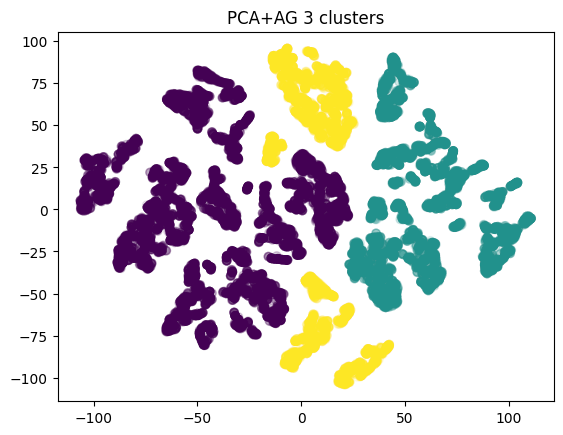

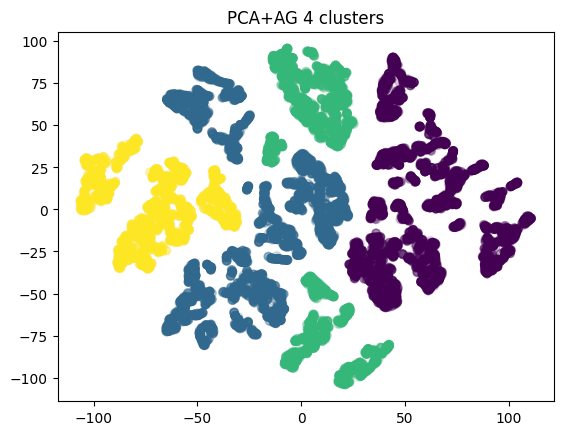

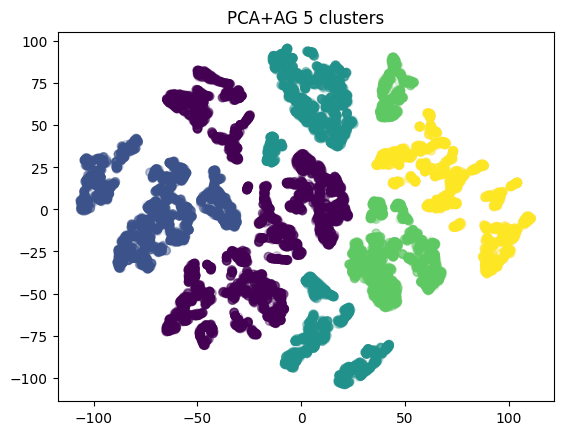

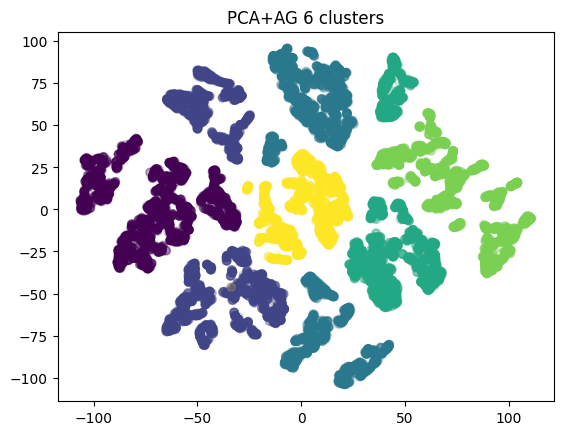

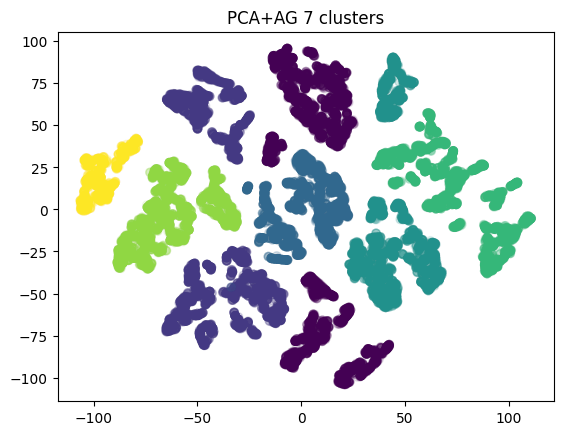

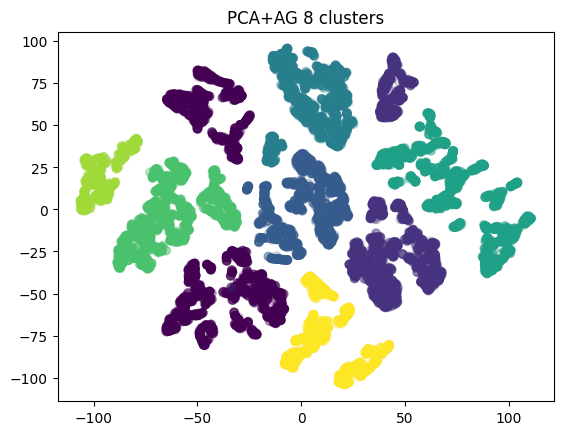

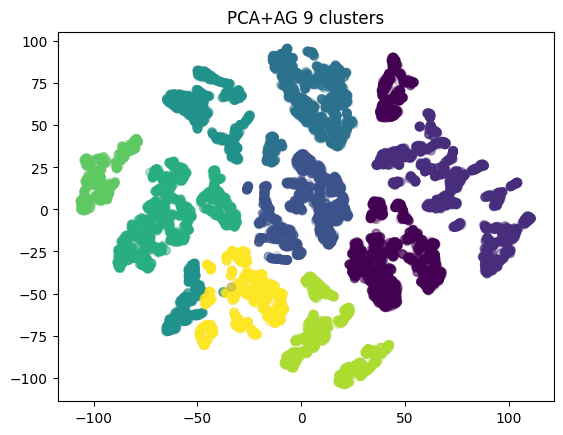

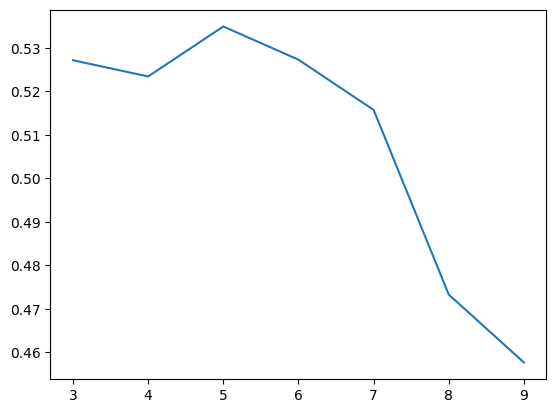

In [43]:
print("Agglomerative clustering")
rez_silh['ag']=[]
rez_ag = {0:[],1:[],2:[],3:[],4:[]}
for (i,k) in ag:
    clusters = k.fit_predict(red_data)
    if i==5:
        for c in range(len(clusters)):
            rez_ag[clusters[c]].append(applications.iloc[c]['ID'])
    rez_silh['ag'].append(silhouette_score(applications,clusters))
    plot_clusters(r_T[0],r_T[1],clusters,"PCA+AG "+str(i)+" clusters")
plot_dict(x_vals, rez_silh['ag'])

#Ubaci i dendogram za AG

In [44]:
for i in rez_ag.keys():
    for j in range(len(rez_ag[i])):
        id = rez_ag[i][j]
        rez_ag[i][j] = id_to_balance[id]

## HDBSCAN

HDBSCAN


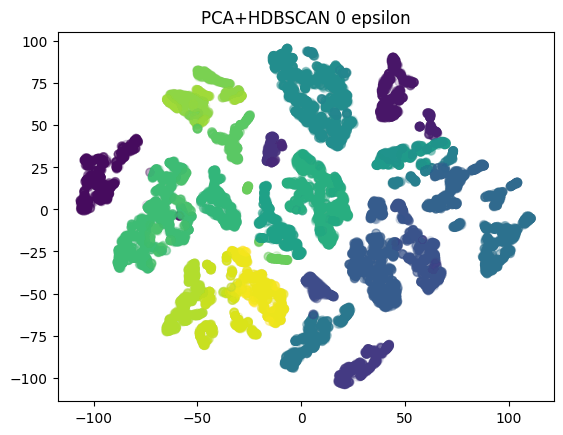

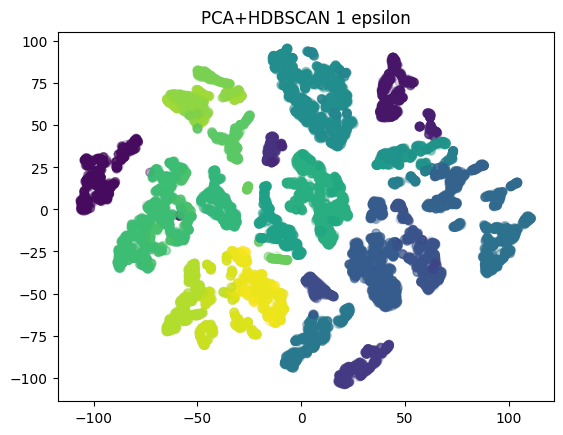

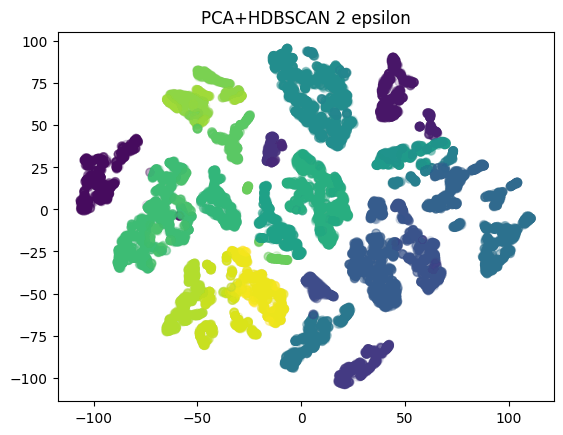

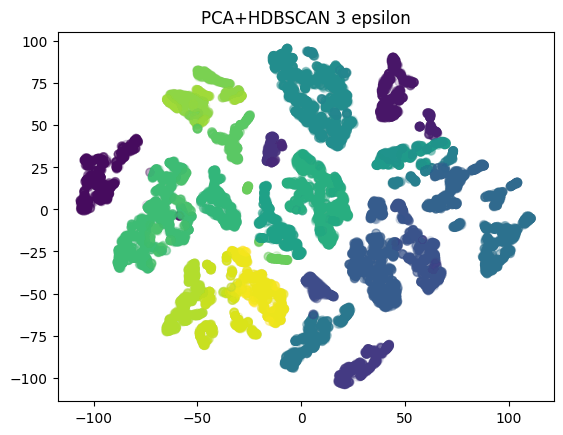

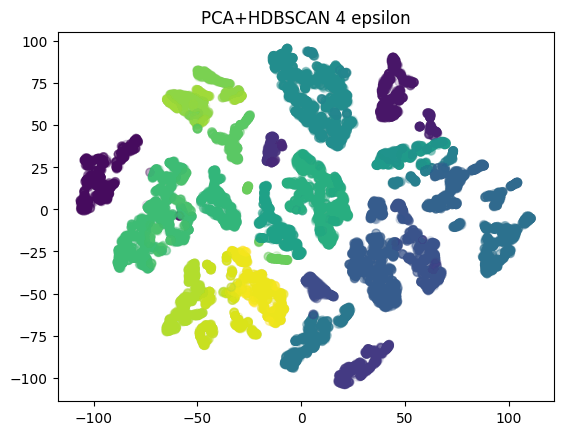

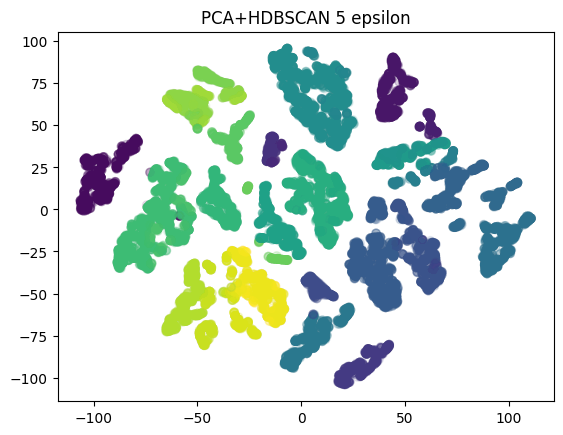

In [45]:
hdb = []
eps = 0

while eps <=5:
    hdb.append((eps,HDBSCAN(cluster_selection_epsilon=eps, min_cluster_size=50)))
    eps+=1

print("HDBSCAN")
for (i,k) in hdb:
    clusters = k.fit_predict(red_data)
    plot_clusters(r_T[0],r_T[1],clusters,"PCA+HDBSCAN "+str(i)+" epsilon")

HDBSCAN
16


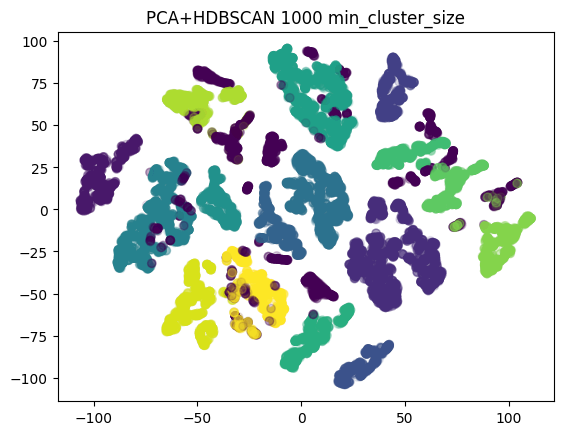

7


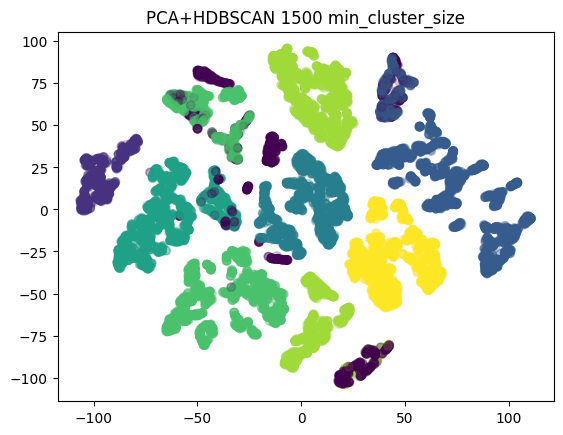

6


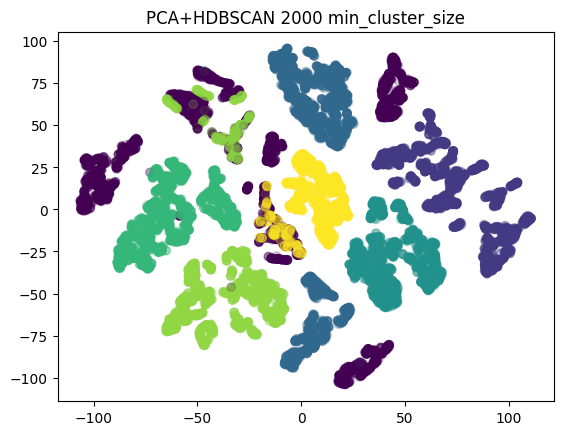

4


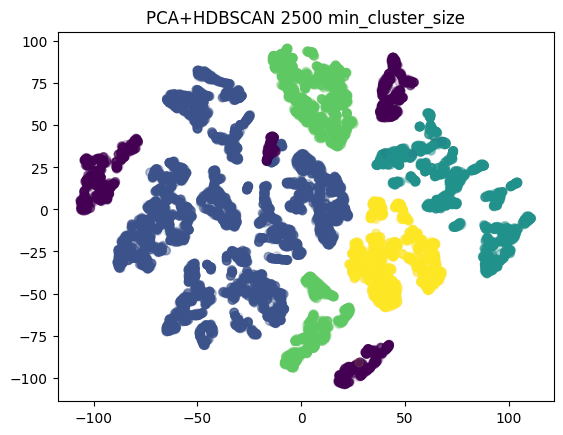

4


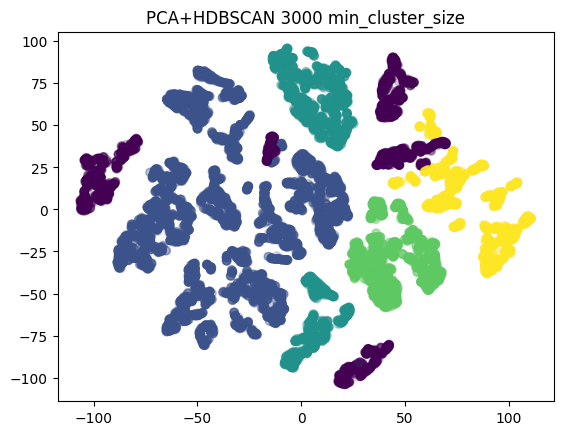

3


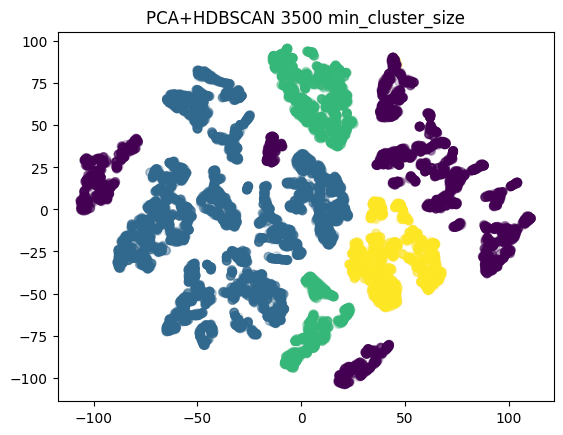

3


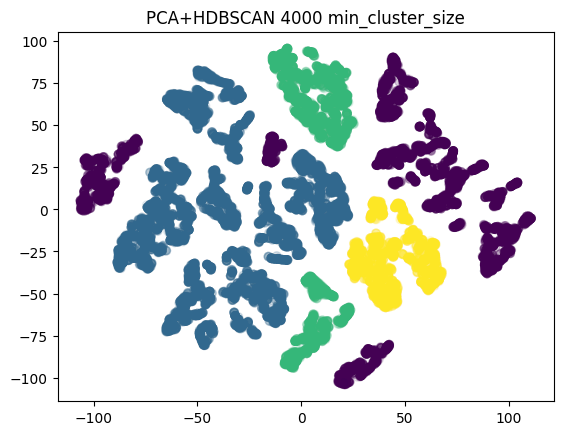

2


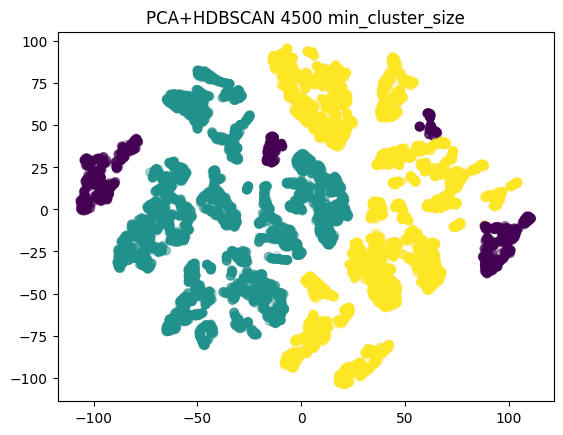

2


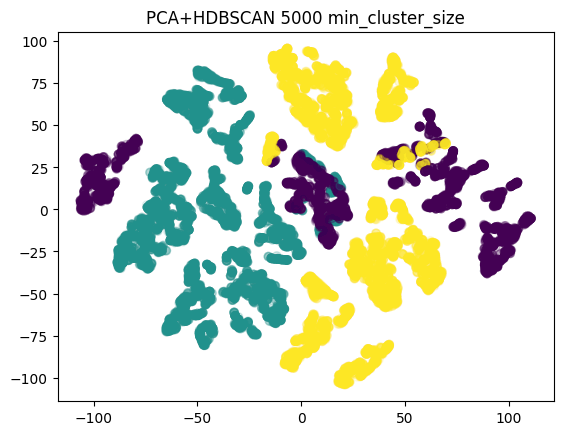

In [46]:
hdb = []
mcs = 1000
rez_hdb = {-1:[],0:[],1:[],2:[]}
while mcs <= 5000:
    hdb.append((mcs,HDBSCAN(min_cluster_size=mcs)))
    mcs+=500

print("HDBSCAN")
for (i,k) in hdb:
    clusters = k.fit_predict(red_data)
    if i==3500:
        for c in range(len(clusters)):
            rez_hdb[clusters[c]].append(applications.iloc[c]['ID'])
    print(clusters.max()+1)
    plot_clusters(r_T[0],r_T[1],clusters,"PCA+HDBSCAN "+str(i)+" min_cluster_size")

In [47]:
for i in rez_hdb.keys():
    for j in range(len(rez_hdb[i])):
        id = rez_hdb[i][j]
        rez_hdb[i][j] = id_to_balance[id]

# Interpretacija rezultata

In [48]:
# Pravi histogram srednjih vrednosti kasnjenja placanja korisnika - zelimo da tezi sto manjoj vrednosti (-2 ili -1)
def draw_results_mean(data):
    for j in data.keys():
        test = []
        for i in range(len(data[j])):
            test.append(np.mean(data[j][i]))
        plt.hist(test, weights=np.ones(len(test)) / len(test), bins=[-2,-1,0,1,2,3,4,5])
        plt.legend([j])
        plt.show()
# Za svakog korisnika uzima maksimum kao njegovo dugovanje, gleda najgori slucaj
def draw_results_max(data):
    for j in data.keys():
        test = []
        for i in range(len(data[j])):
            test.append(np.max(data[j][i]))
        values, counts = np.unique(test, return_counts=True)
        plt.plot(values, counts)
    plt.legend(data.keys())
    plt.show()
# Za svakog korisnika uzima maksimum kao njegovo dugovanje, gleda najgori slucaj
def draw_results_latest(data):
    for j in data.keys():
        test = []
        for i in range(len(data[j])):
            test.append(data[j][i][0])
        values, counts = np.unique(test, return_counts=True)
        plt.plot(values, counts)
    plt.legend(data.keys())
    plt.show()

def draw_results_length(data):
    for j in data.keys():
        test = []
        for i in range(len(data[j])):
            test.append(len(data[j][i]))
        values, counts = np.unique(test, return_counts=True)
        plt.plot(values, counts)
    plt.legend(data.keys())
    plt.show()

## KMeans

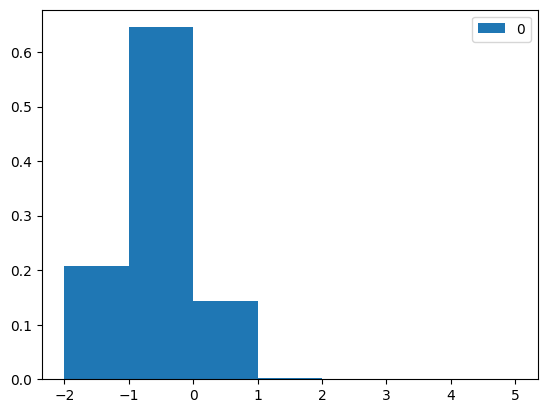

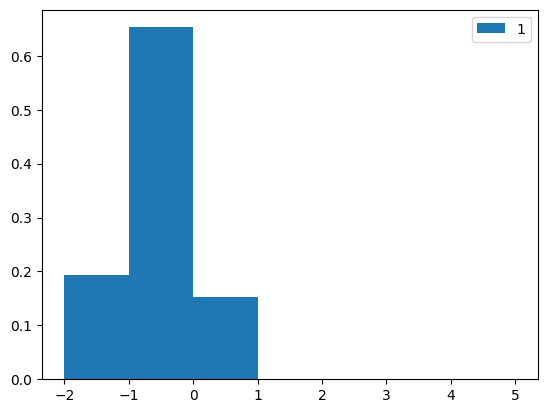

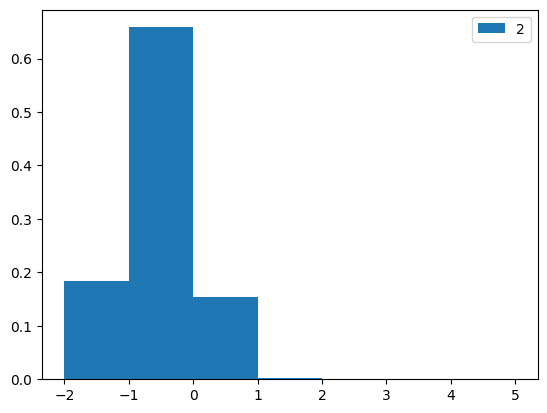

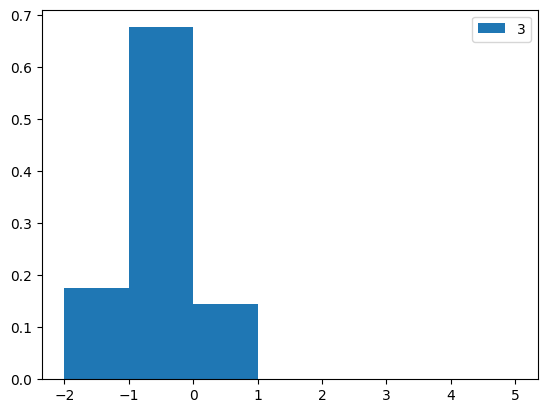

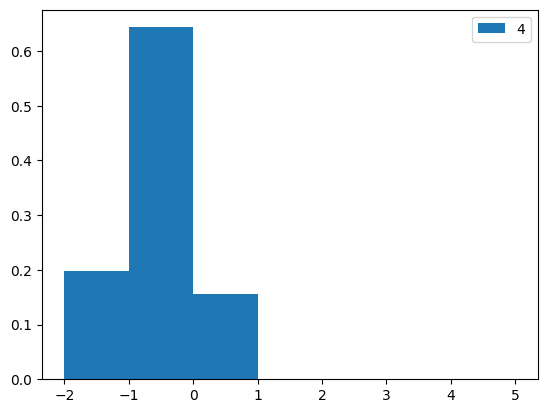

In [49]:
draw_results_mean(rez_km)

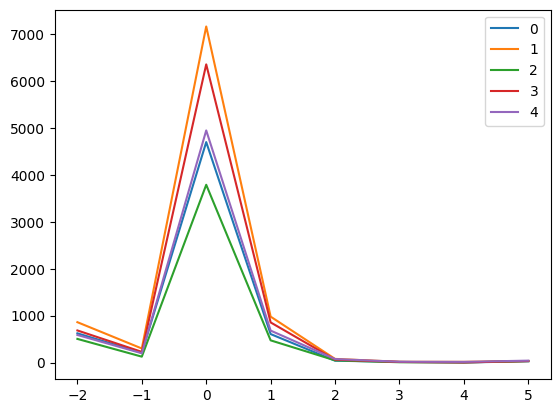

In [50]:
draw_results_max(rez_km)

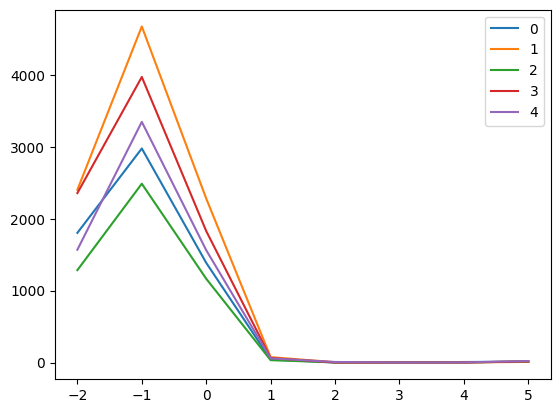

In [51]:
draw_results_latest(rez_km)

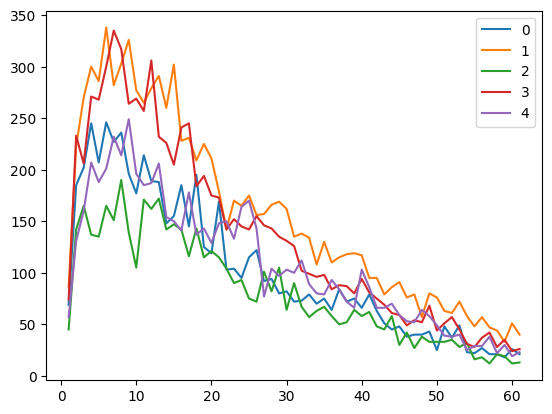

In [52]:
draw_results_length(rez_km)

## Agglomerative Clustering

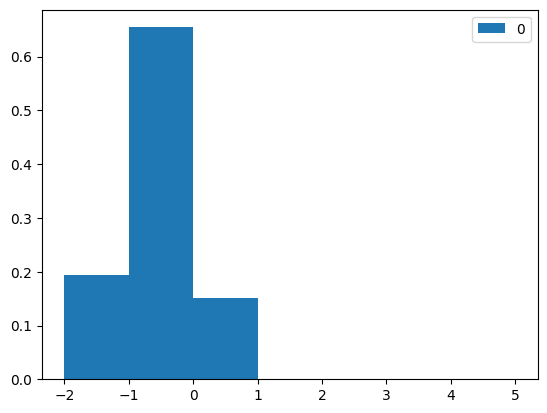

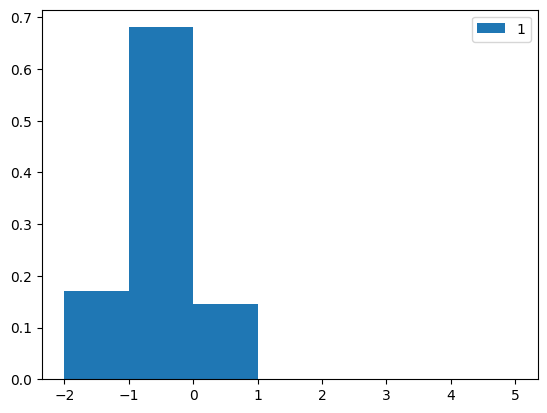

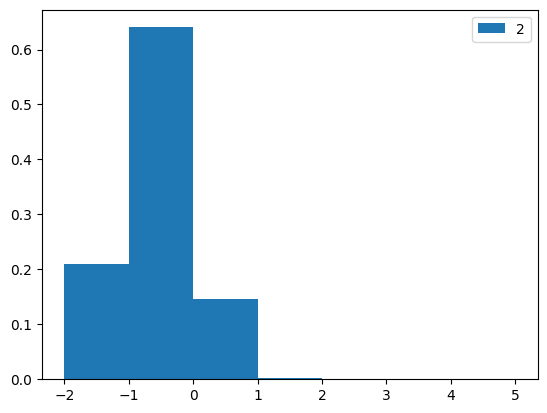

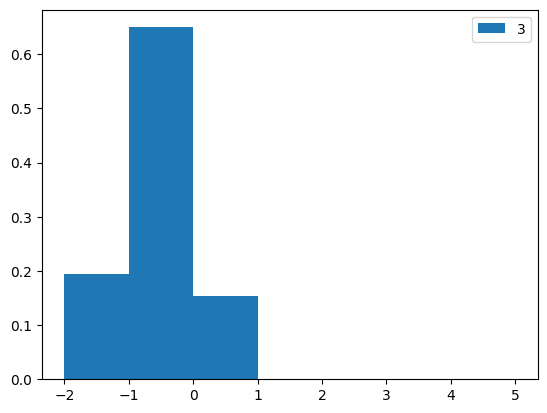

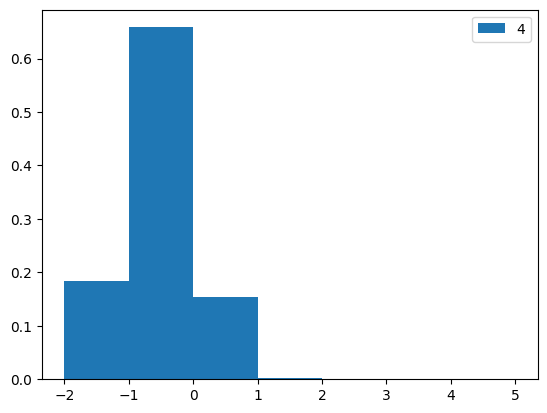

In [53]:
draw_results_mean(rez_ag)

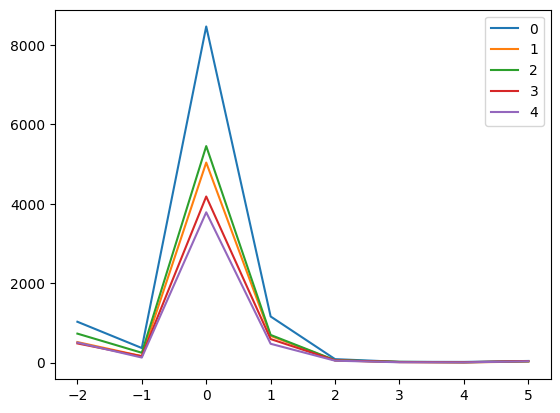

In [54]:
draw_results_max(rez_ag)

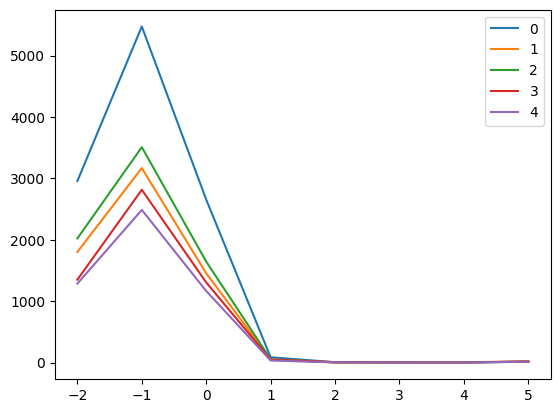

In [55]:
draw_results_latest(rez_ag)

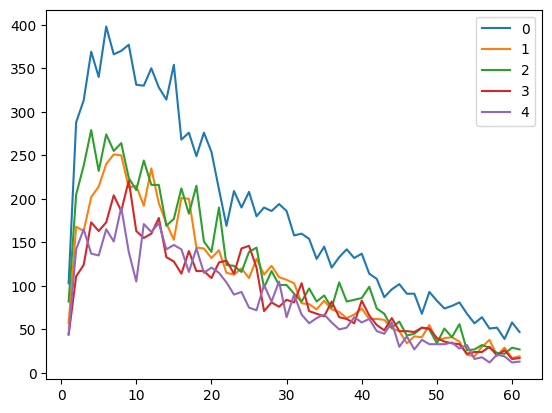

In [56]:
draw_results_length(rez_ag)

## HDBSCAN

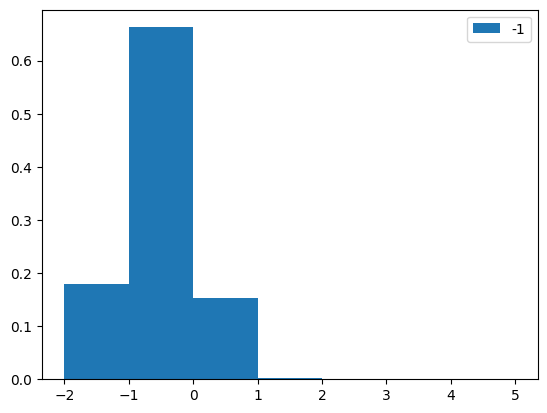

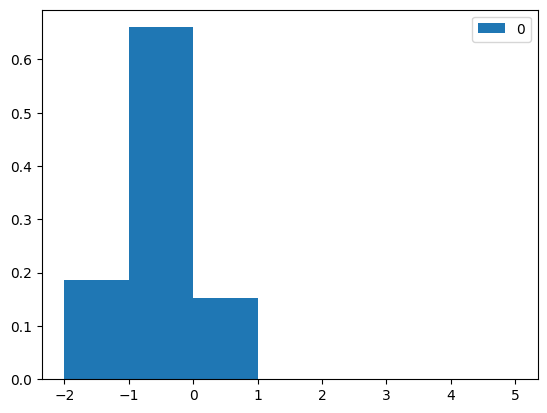

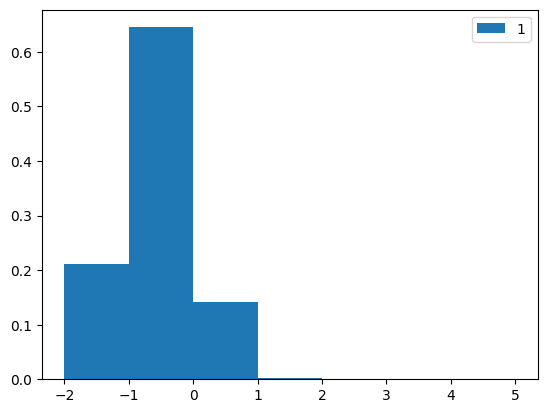

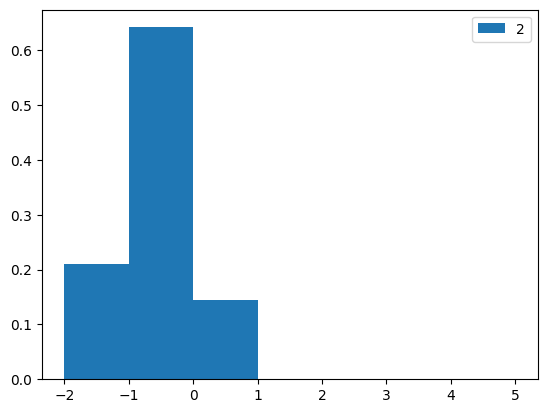

In [57]:
draw_results_mean(rez_hdb)

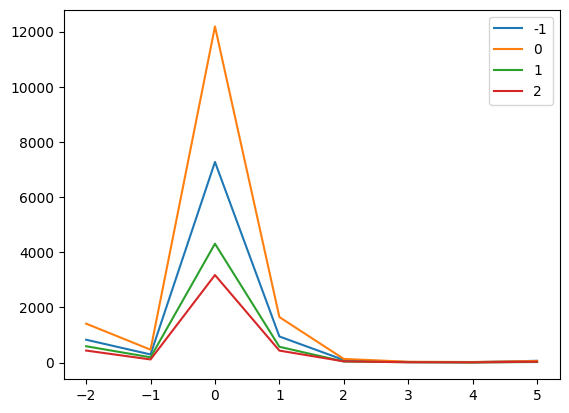

In [58]:
draw_results_max(rez_hdb)

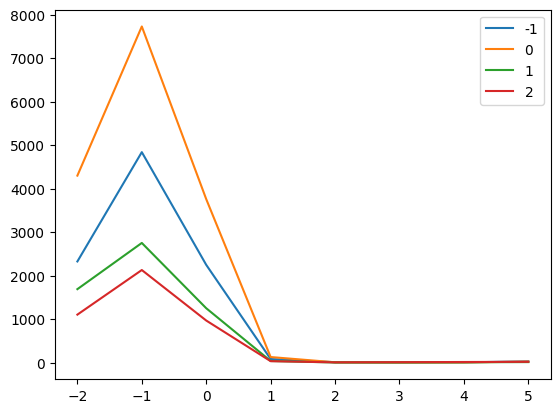

In [59]:
draw_results_latest(rez_hdb)

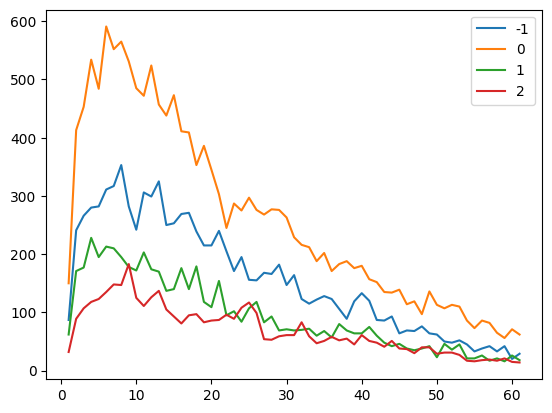

In [60]:
draw_results_length(rez_hdb)